# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ac      1206 non-null   int64 
 1   wis     1206 non-null   int64 
 2   cha     1206 non-null   int64 
 3   dex     1206 non-null   int64 
 4   hp      1206 non-null   int64 
 5   book    1206 non-null   object
 6   level   1206 non-null   int64 
 7   str     1206 non-null   int64 
 8   con     1206 non-null   int64 
 9   int     1206 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 103.6+ KB


In [3]:
df.head()

,ac,wis,cha,dex,hp,book,level,str,con,int
0,29,2,1,2,215,Pathfinder Bestiary,10,7,5,1
1,28,2,1,0,220,Pathfinder Bestiary,10,9,5,-4
2,25,3,-2,3,175,Pathfinder Bestiary,8,7,6,-4
3,41,5,6,4,315,Pathfinder Bestiary,17,7,5,6
4,16,1,1,3,20,Pathfinder Bestiary,1,-5,1,-1


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


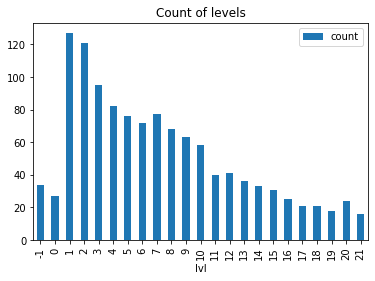

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 8
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.45
RMSE: 0.67
MAE: 0.47


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "basic", rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.31
RMSE test: 0.67


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

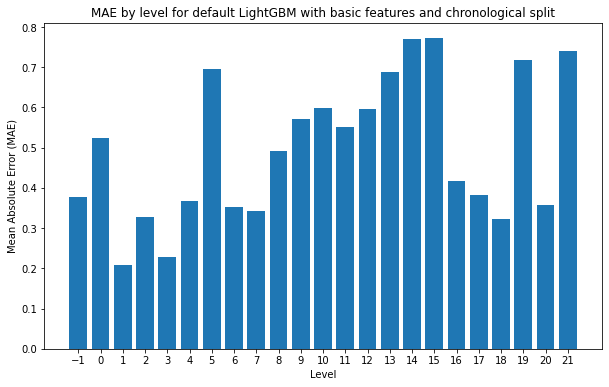

In [18]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and chronological split",
)

In [19]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Default:
MSE: 0.45
RMSE: 0.67

Round type: round
MSE: 0.50
RMSE: 0.71

Round type: 0.33
MSE: 0.50
RMSE: 0.71

Round type: 0.45
MSE: 0.48
RMSE: 0.70



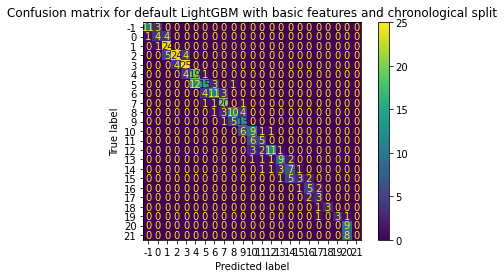

In [20]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with basic features and chronological split",
)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 11:49:38,865] A new study created in memory with name: no-name-c4ccc06d-b281-47bb-8430-35550e77cfce
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.240137 + 0.0376968
[200]	cv_agg's l2: 0.227663 + 0.0411709
[300]	cv_agg's l2: 0.225921 + 0.0412165


feature_fraction, val_score: 0.225402:  14%|######4                                      | 1/7 [00:01<00:07,  1.23s/it]

[400]	cv_agg's l2: 0.226246 + 0.0412173
Early stopping, best iteration is:
[309]	cv_agg's l2: 0.225402 + 0.0416336
[100]	cv_agg's l2: 0.26839 + 0.0519747
[200]	cv_agg's l2: 0.245845 + 0.05191
[300]	cv_agg's l2: 0.241199 + 0.0520364


feature_fraction, val_score: 0.225402:  29%|############8                                | 2/7 [00:02<00:05,  1.19s/it]

[400]	cv_agg's l2: 0.239491 + 0.0526465
Early stopping, best iteration is:
[309]	cv_agg's l2: 0.225402 + 0.0416336
[100]	cv_agg's l2: 0.234102 + 0.0514901
[200]	cv_agg's l2: 0.232555 + 0.0495999
[300]	cv_agg's l2: 0.234555 + 0.0509719


feature_fraction, val_score: 0.225402:  43%|###################2                         | 3/7 [00:03<00:04,  1.22s/it]

[400]	cv_agg's l2: 0.238087 + 0.0528755
Early stopping, best iteration is:
[309]	cv_agg's l2: 0.225402 + 0.0416336
[100]	cv_agg's l2: 0.231267 + 0.0454498
[200]	cv_agg's l2: 0.227682 + 0.0459242
[300]	cv_agg's l2: 0.227877 + 0.0449849


feature_fraction, val_score: 0.225402:  57%|#########################7                   | 4/7 [00:05<00:03,  1.29s/it]

[400]	cv_agg's l2: 0.229591 + 0.0457401
Early stopping, best iteration is:
[309]	cv_agg's l2: 0.225402 + 0.0416336
[100]	cv_agg's l2: 0.400607 + 0.0848832
[200]	cv_agg's l2: 0.337446 + 0.0784102
[300]	cv_agg's l2: 0.316575 + 0.0769797


feature_fraction, val_score: 0.225402:  71%|################################1            | 5/7 [00:06<00:02,  1.25s/it]

[400]	cv_agg's l2: 0.304168 + 0.074502
Early stopping, best iteration is:
[309]	cv_agg's l2: 0.225402 + 0.0416336
[100]	cv_agg's l2: 0.255755 + 0.0504043
[200]	cv_agg's l2: 0.238036 + 0.049283
[300]	cv_agg's l2: 0.234756 + 0.0510297


feature_fraction, val_score: 0.225402:  86%|######################################5      | 6/7 [00:07<00:01,  1.22s/it]

[400]	cv_agg's l2: 0.235028 + 0.0518991
Early stopping, best iteration is:
[309]	cv_agg's l2: 0.225402 + 0.0416336
[100]	cv_agg's l2: 0.240137 + 0.0376968
[200]	cv_agg's l2: 0.227663 + 0.0411709
[300]	cv_agg's l2: 0.225921 + 0.0412165


feature_fraction, val_score: 0.225402: 100%|#############################################| 7/7 [00:08<00:00,  1.24s/it]


[400]	cv_agg's l2: 0.226246 + 0.0412173
Early stopping, best iteration is:
[309]	cv_agg's l2: 0.225402 + 0.0416336


num_leaves, val_score: 0.225402:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.240137 + 0.0376968
[200]	cv_agg's l2: 0.227663 + 0.0411709
[300]	cv_agg's l2: 0.225921 + 0.0412165


num_leaves, val_score: 0.225402:   5%|##5                                               | 1/20 [00:01<00:25,  1.32s/it]

[400]	cv_agg's l2: 0.226246 + 0.0412173
Early stopping, best iteration is:
[309]	cv_agg's l2: 0.225402 + 0.0416336
[100]	cv_agg's l2: 0.240137 + 0.0376968
[200]	cv_agg's l2: 0.227663 + 0.0411709
[300]	cv_agg's l2: 0.225921 + 0.0412165


num_leaves, val_score: 0.225402:  10%|#####                                             | 2/20 [00:02<00:24,  1.35s/it]

[400]	cv_agg's l2: 0.226246 + 0.0412173
Early stopping, best iteration is:
[309]	cv_agg's l2: 0.225402 + 0.0416336
[100]	cv_agg's l2: 0.240137 + 0.0376968
[200]	cv_agg's l2: 0.227663 + 0.0411709
[300]	cv_agg's l2: 0.225921 + 0.0412165


num_leaves, val_score: 0.225402:  15%|#######5                                          | 3/20 [00:03<00:22,  1.30s/it]

[400]	cv_agg's l2: 0.226246 + 0.0412173
Early stopping, best iteration is:
[309]	cv_agg's l2: 0.225402 + 0.0416336
[100]	cv_agg's l2: 0.270824 + 0.0486191


num_leaves, val_score: 0.225402:  15%|#######5                                          | 3/20 [00:04<00:22,  1.30s/it]

[200]	cv_agg's l2: 0.251432 + 0.0478577
[300]	cv_agg's l2: 0.240843 + 0.043845
[400]	cv_agg's l2: 0.236036 + 0.041816
Early stopping, best iteration is:
[309]	cv_agg's l2: 0.225402 + 0.0416336


num_leaves, val_score: 0.225402:  20%|##########                                        | 4/20 [00:04<00:15,  1.05it/s]

[100]	cv_agg's l2: 0.240137 + 0.0376968
[200]	cv_agg's l2: 0.227663 + 0.0411709
[300]	cv_agg's l2: 0.225921 + 0.0412165


num_leaves, val_score: 0.225402:  25%|############5                                     | 5/20 [00:05<00:16,  1.08s/it]

[400]	cv_agg's l2: 0.226246 + 0.0412173
Early stopping, best iteration is:
[309]	cv_agg's l2: 0.225402 + 0.0416336
[100]	cv_agg's l2: 0.240137 + 0.0376968
[200]	cv_agg's l2: 0.227663 + 0.0411709
[300]	cv_agg's l2: 0.225921 + 0.0412165


num_leaves, val_score: 0.225402:  30%|###############                                   | 6/20 [00:07<00:16,  1.21s/it]

[400]	cv_agg's l2: 0.226246 + 0.0412173
Early stopping, best iteration is:
[309]	cv_agg's l2: 0.225402 + 0.0416336
[100]	cv_agg's l2: 0.254418 + 0.0481568
[200]	cv_agg's l2: 0.234805 + 0.0448275
[300]	cv_agg's l2: 0.227086 + 0.0401386
[400]	cv_agg's l2: 0.22199 + 0.0402208
[500]	cv_agg's l2: 0.219819 + 0.0387303
[600]	cv_agg's l2: 0.218664 + 0.0378498
[700]	cv_agg's l2: 0.21784 + 0.0376591
[800]	cv_agg's l2: 0.217301 + 0.0372224


num_leaves, val_score: 0.215479:  30%|###############                                   | 6/20 [00:08<00:16,  1.21s/it]

[900]	cv_agg's l2: 0.216338 + 0.0369447
[1000]	cv_agg's l2: 0.2157 + 0.036922
Early stopping, best iteration is:
[953]	cv_agg's l2: 0.215479 + 0.0367778


num_leaves, val_score: 0.215479:  35%|#################5                                | 7/20 [00:08<00:16,  1.26s/it]

[100]	cv_agg's l2: 0.239553 + 0.0361808
[200]	cv_agg's l2: 0.226522 + 0.0392979
[300]	cv_agg's l2: 0.224128 + 0.0392306
[400]	cv_agg's l2: 0.222192 + 0.0390136
[500]	cv_agg's l2: 0.2216 + 0.0384337
[600]	cv_agg's l2: 0.22201 + 0.0381404
[700]	cv_agg's l2: 0.222507 + 0.0382801
[800]	cv_agg's l2: 0.223431 + 0.0380945
[900]	cv_agg's l2: 0.224177 + 0.0379862
[1000]	cv_agg's l2: 0.224677 + 0.0375201


num_leaves, val_score: 0.215479:  40%|####################                              | 8/20 [00:11<00:19,  1.67s/it]

Early stopping, best iteration is:
[953]	cv_agg's l2: 0.215479 + 0.0367778
[100]	cv_agg's l2: 0.258498 + 0.0440349
[200]	cv_agg's l2: 0.239061 + 0.0447395
[300]	cv_agg's l2: 0.22945 + 0.0411133
[400]	cv_agg's l2: 0.223241 + 0.0374186
[500]	cv_agg's l2: 0.221098 + 0.0347735
[600]	cv_agg's l2: 0.218601 + 0.033899
[700]	cv_agg's l2: 0.21681 + 0.0316424
[800]	cv_agg's l2: 0.215535 + 0.0306523
[900]	cv_agg's l2: 0.215172 + 0.0307633
[1000]	cv_agg's l2: 0.21457 + 0.0308681
[1100]	cv_agg's l2: 0.214331 + 0.0304567
[1200]	cv_agg's l2: 0.213715 + 0.0307469
[1300]	cv_agg's l2: 0.213174 + 0.0310664
[1400]	cv_agg's l2: 0.213012 + 0.0311329


num_leaves, val_score: 0.212522:  45%|######################5                           | 9/20 [00:12<00:18,  1.65s/it]

Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628
[100]	cv_agg's l2: 0.240137 + 0.0376968
[200]	cv_agg's l2: 0.227663 + 0.0411709
[300]	cv_agg's l2: 0.225921 + 0.0412165
[400]	cv_agg's l2: 0.226246 + 0.0412173
[500]	cv_agg's l2: 0.226796 + 0.0418535
[600]	cv_agg's l2: 0.22801 + 0.0420775
[700]	cv_agg's l2: 0.229597 + 0.0423549
[800]	cv_agg's l2: 0.23075 + 0.0426852
[900]	cv_agg's l2: 0.232185 + 0.0427983
[1000]	cv_agg's l2: 0.233111 + 0.0426226
[1100]	cv_agg's l2: 0.234334 + 0.04256
[1200]	cv_agg's l2: 0.235168 + 0.0424906
[1300]	cv_agg's l2: 0.23603 + 0.0424895
[1400]	cv_agg's l2: 0.236673 + 0.0421704
Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628


num_leaves, val_score: 0.212522:  50%|########################5                        | 10/20 [00:17<00:25,  2.51s/it]

[100]	cv_agg's l2: 0.240137 + 0.0376968
[200]	cv_agg's l2: 0.227663 + 0.0411709
[300]	cv_agg's l2: 0.225921 + 0.0412165
[400]	cv_agg's l2: 0.226246 + 0.0412173
[500]	cv_agg's l2: 0.226796 + 0.0418535
[600]	cv_agg's l2: 0.22801 + 0.0420775
[700]	cv_agg's l2: 0.229597 + 0.0423549
[800]	cv_agg's l2: 0.23075 + 0.0426852
[900]	cv_agg's l2: 0.232185 + 0.0427983
[1000]	cv_agg's l2: 0.233111 + 0.0426226
[1100]	cv_agg's l2: 0.234334 + 0.04256
[1200]	cv_agg's l2: 0.235168 + 0.0424906
[1300]	cv_agg's l2: 0.23603 + 0.0424895
[1400]	cv_agg's l2: 0.236673 + 0.0421704


num_leaves, val_score: 0.212522:  55%|##########################9                      | 11/20 [00:21<00:28,  3.20s/it]

Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628
[100]	cv_agg's l2: 0.270824 + 0.0486191
[200]	cv_agg's l2: 0.251432 + 0.0478577
[300]	cv_agg's l2: 0.240843 + 0.043845
[400]	cv_agg's l2: 0.236036 + 0.041816
[500]	cv_agg's l2: 0.232033 + 0.0384844
[600]	cv_agg's l2: 0.230125 + 0.0359821
[700]	cv_agg's l2: 0.228224 + 0.0338702
[800]	cv_agg's l2: 0.226243 + 0.0319081
[900]	cv_agg's l2: 0.226004 + 0.0310519
[1000]	cv_agg's l2: 0.224919 + 0.0302288
[1100]	cv_agg's l2: 0.224236 + 0.0295239
[1200]	cv_agg's l2: 0.223884 + 0.0291836
[1300]	cv_agg's l2: 0.222732 + 0.0296644
[1400]	cv_agg's l2: 0.222535 + 0.0297744


num_leaves, val_score: 0.212522:  60%|#############################4                   | 12/20 [00:23<00:22,  2.75s/it]

Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628
[100]	cv_agg's l2: 0.240137 + 0.0376968
[200]	cv_agg's l2: 0.227663 + 0.0411709
[300]	cv_agg's l2: 0.225921 + 0.0412165
[400]	cv_agg's l2: 0.226246 + 0.0412173
[500]	cv_agg's l2: 0.226796 + 0.0418535
[600]	cv_agg's l2: 0.22801 + 0.0420775
[700]	cv_agg's l2: 0.229597 + 0.0423549
[800]	cv_agg's l2: 0.23075 + 0.0426852
[900]	cv_agg's l2: 0.232185 + 0.0427983
[1000]	cv_agg's l2: 0.233111 + 0.0426226
[1100]	cv_agg's l2: 0.234334 + 0.04256
[1200]	cv_agg's l2: 0.235168 + 0.0424906
[1300]	cv_agg's l2: 0.23603 + 0.0424895
[1400]	cv_agg's l2: 0.236673 + 0.0421704
Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628


num_leaves, val_score: 0.212522:  65%|###############################8                 | 13/20 [00:31<00:29,  4.19s/it]

[100]	cv_agg's l2: 0.240137 + 0.0376968
[200]	cv_agg's l2: 0.227663 + 0.0411709
[300]	cv_agg's l2: 0.225921 + 0.0412165
[400]	cv_agg's l2: 0.226246 + 0.0412173
[500]	cv_agg's l2: 0.226796 + 0.0418535
[600]	cv_agg's l2: 0.22801 + 0.0420775
[700]	cv_agg's l2: 0.229597 + 0.0423549
[800]	cv_agg's l2: 0.23075 + 0.0426852
[900]	cv_agg's l2: 0.232185 + 0.0427983
[1000]	cv_agg's l2: 0.233111 + 0.0426226
[1100]	cv_agg's l2: 0.234334 + 0.04256
[1200]	cv_agg's l2: 0.235168 + 0.0424906
[1300]	cv_agg's l2: 0.23603 + 0.0424895
[1400]	cv_agg's l2: 0.236673 + 0.0421704
Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628


num_leaves, val_score: 0.212522:  70%|##################################3              | 14/20 [00:35<00:26,  4.39s/it]

[100]	cv_agg's l2: 0.240819 + 0.038895
[200]	cv_agg's l2: 0.22997 + 0.0406461
[300]	cv_agg's l2: 0.226616 + 0.0410186
[400]	cv_agg's l2: 0.226607 + 0.04186
[500]	cv_agg's l2: 0.227965 + 0.042386
[600]	cv_agg's l2: 0.228948 + 0.0423347
[700]	cv_agg's l2: 0.229889 + 0.0419499
[800]	cv_agg's l2: 0.230943 + 0.0422884
[900]	cv_agg's l2: 0.232342 + 0.0422039
[1000]	cv_agg's l2: 0.233128 + 0.0424605
[1100]	cv_agg's l2: 0.234243 + 0.0424626
[1200]	cv_agg's l2: 0.235204 + 0.0422288
[1300]	cv_agg's l2: 0.235988 + 0.0421242
[1400]	cv_agg's l2: 0.236655 + 0.0421055
Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628


num_leaves, val_score: 0.212522:  75%|####################################7            | 15/20 [00:40<00:21,  4.35s/it]

[100]	cv_agg's l2: 0.240137 + 0.0376968
[200]	cv_agg's l2: 0.227663 + 0.0411709
[300]	cv_agg's l2: 0.225921 + 0.0412165
[400]	cv_agg's l2: 0.226246 + 0.0412173
[500]	cv_agg's l2: 0.226796 + 0.0418535
[600]	cv_agg's l2: 0.22801 + 0.0420775
[700]	cv_agg's l2: 0.229597 + 0.0423549
[800]	cv_agg's l2: 0.23075 + 0.0426852
[900]	cv_agg's l2: 0.232185 + 0.0427983
[1000]	cv_agg's l2: 0.233111 + 0.0426226
[1100]	cv_agg's l2: 0.234334 + 0.04256
[1200]	cv_agg's l2: 0.235168 + 0.0424906
[1300]	cv_agg's l2: 0.23603 + 0.0424895


num_leaves, val_score: 0.212522:  75%|####################################7            | 15/20 [00:44<00:21,  4.35s/it]

[1400]	cv_agg's l2: 0.236673 + 0.0421704
Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628


num_leaves, val_score: 0.212522:  80%|#######################################2         | 16/20 [00:44<00:17,  4.39s/it]

[100]	cv_agg's l2: 0.315883 + 0.0549709
[200]	cv_agg's l2: 0.27007 + 0.0440472
[300]	cv_agg's l2: 0.257623 + 0.0424323
[400]	cv_agg's l2: 0.249066 + 0.0398527
[500]	cv_agg's l2: 0.243467 + 0.0382935
[600]	cv_agg's l2: 0.239327 + 0.0358259
[700]	cv_agg's l2: 0.23666 + 0.0344608
[800]	cv_agg's l2: 0.233677 + 0.0332502
[900]	cv_agg's l2: 0.231755 + 0.030837
[1000]	cv_agg's l2: 0.231036 + 0.0302677
[1100]	cv_agg's l2: 0.229346 + 0.0285356
[1200]	cv_agg's l2: 0.227546 + 0.0283331


num_leaves, val_score: 0.212522:  85%|#########################################6       | 17/20 [00:45<00:10,  3.44s/it]

[1300]	cv_agg's l2: 0.226932 + 0.0279627
[1400]	cv_agg's l2: 0.226204 + 0.0276207
Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628
[100]	cv_agg's l2: 0.240137 + 0.0376968
[200]	cv_agg's l2: 0.227663 + 0.0411709
[300]	cv_agg's l2: 0.225921 + 0.0412165
[400]	cv_agg's l2: 0.226246 + 0.0412173
[500]	cv_agg's l2: 0.226796 + 0.0418535
[600]	cv_agg's l2: 0.22801 + 0.0420775
[700]	cv_agg's l2: 0.229597 + 0.0423549
[800]	cv_agg's l2: 0.23075 + 0.0426852
[900]	cv_agg's l2: 0.232185 + 0.0427983
[1000]	cv_agg's l2: 0.233111 + 0.0426226
[1100]	cv_agg's l2: 0.234334 + 0.04256
[1200]	cv_agg's l2: 0.235168 + 0.0424906
[1300]	cv_agg's l2: 0.23603 + 0.0424895
[1400]	cv_agg's l2: 0.236673 + 0.0421704


num_leaves, val_score: 0.212522:  90%|############################################1    | 18/20 [00:50<00:07,  3.76s/it]

Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628
[100]	cv_agg's l2: 0.240137 + 0.0376968
[200]	cv_agg's l2: 0.227663 + 0.0411709
[300]	cv_agg's l2: 0.225921 + 0.0412165
[400]	cv_agg's l2: 0.226246 + 0.0412173
[500]	cv_agg's l2: 0.226796 + 0.0418535
[600]	cv_agg's l2: 0.22801 + 0.0420775
[700]	cv_agg's l2: 0.229597 + 0.0423549
[800]	cv_agg's l2: 0.23075 + 0.0426852
[900]	cv_agg's l2: 0.232185 + 0.0427983
[1000]	cv_agg's l2: 0.233111 + 0.0426226
[1100]	cv_agg's l2: 0.234334 + 0.04256
[1200]	cv_agg's l2: 0.235168 + 0.0424906
[1300]	cv_agg's l2: 0.23603 + 0.0424895
[1400]	cv_agg's l2: 0.236673 + 0.0421704
Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628


num_leaves, val_score: 0.212522:  95%|##############################################5  | 19/20 [00:55<00:04,  4.12s/it]

[100]	cv_agg's l2: 0.240137 + 0.0376968
[200]	cv_agg's l2: 0.227663 + 0.0411709
[300]	cv_agg's l2: 0.225921 + 0.0412165
[400]	cv_agg's l2: 0.226246 + 0.0412173
[500]	cv_agg's l2: 0.226796 + 0.0418535
[600]	cv_agg's l2: 0.22801 + 0.0420775
[700]	cv_agg's l2: 0.229597 + 0.0423549
[800]	cv_agg's l2: 0.23075 + 0.0426852
[900]	cv_agg's l2: 0.232185 + 0.0427983
[1000]	cv_agg's l2: 0.233111 + 0.0426226
[1100]	cv_agg's l2: 0.234334 + 0.04256
[1200]	cv_agg's l2: 0.235168 + 0.0424906
[1300]	cv_agg's l2: 0.23603 + 0.0424895


num_leaves, val_score: 0.212522:  95%|##############################################5  | 19/20 [00:59<00:04,  4.12s/it]

[1400]	cv_agg's l2: 0.236673 + 0.0421704
Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628


bagging, val_score: 0.212522:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.314934 + 0.059538
[200]	cv_agg's l2: 0.30148 + 0.0558044
[300]	cv_agg's l2: 0.292019 + 0.0541363
[400]	cv_agg's l2: 0.285218 + 0.051466
[500]	cv_agg's l2: 0.277737 + 0.0567462
[600]	cv_agg's l2: 0.277581 + 0.0603072
[700]	cv_agg's l2: 0.272288 + 0.0582173
[800]	cv_agg's l2: 0.27054 + 0.0554555
[900]	cv_agg's l2: 0.268809 + 0.0554231
[1000]	cv_agg's l2: 0.265926 + 0.0575633
[1100]	cv_agg's l2: 0.272497 + 0.0540315
[1200]	cv_agg's l2: 0.27009 + 0.0553895


bagging, val_score: 0.212522:   0%|                                                             | 0/10 [00:01<?, ?it/s]

[1300]	cv_agg's l2: 0.271899 + 0.0565124
[1400]	cv_agg's l2: 0.267706 + 0.060557
Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628


bagging, val_score: 0.212522:  10%|#####3                                               | 1/10 [00:01<00:15,  1.72s/it]

[100]	cv_agg's l2: 0.26427 + 0.0461869
[200]	cv_agg's l2: 0.241284 + 0.0433337
[300]	cv_agg's l2: 0.232682 + 0.0410955
[400]	cv_agg's l2: 0.227215 + 0.0375844
[500]	cv_agg's l2: 0.222919 + 0.0367549
[600]	cv_agg's l2: 0.222005 + 0.0360553
[700]	cv_agg's l2: 0.220219 + 0.0356607
[800]	cv_agg's l2: 0.217941 + 0.0349165
[900]	cv_agg's l2: 0.216689 + 0.0339531
[1000]	cv_agg's l2: 0.217015 + 0.0348579
[1100]	cv_agg's l2: 0.216216 + 0.034056
[1200]	cv_agg's l2: 0.215739 + 0.0345785


bagging, val_score: 0.212522:  10%|#####3                                               | 1/10 [00:03<00:15,  1.72s/it]

[1300]	cv_agg's l2: 0.214979 + 0.0347099
[1400]	cv_agg's l2: 0.214626 + 0.0347788
Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628


bagging, val_score: 0.212522:  20%|##########6                                          | 2/10 [00:03<00:14,  1.82s/it]

[100]	cv_agg's l2: 0.258498 + 0.0440349
[200]	cv_agg's l2: 0.239061 + 0.0447395
[300]	cv_agg's l2: 0.22945 + 0.0411133
[400]	cv_agg's l2: 0.223241 + 0.0374186
[500]	cv_agg's l2: 0.221098 + 0.0347735
[600]	cv_agg's l2: 0.218601 + 0.033899
[700]	cv_agg's l2: 0.21681 + 0.0316424
[800]	cv_agg's l2: 0.215535 + 0.0306523
[900]	cv_agg's l2: 0.215172 + 0.0307633
[1000]	cv_agg's l2: 0.21457 + 0.0308681
[1100]	cv_agg's l2: 0.214331 + 0.0304567
[1200]	cv_agg's l2: 0.213715 + 0.0307469
[1300]	cv_agg's l2: 0.213174 + 0.0310664


bagging, val_score: 0.212522:  30%|###############9                                     | 3/10 [00:05<00:12,  1.74s/it]

[1400]	cv_agg's l2: 0.213012 + 0.0311329
Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628
[100]	cv_agg's l2: 0.262615 + 0.0421607
[200]	cv_agg's l2: 0.23979 + 0.0386863
[300]	cv_agg's l2: 0.232944 + 0.035371
[400]	cv_agg's l2: 0.226667 + 0.0336577
[500]	cv_agg's l2: 0.222679 + 0.0318315
[600]	cv_agg's l2: 0.220004 + 0.0307349
[700]	cv_agg's l2: 0.218933 + 0.0305562
[800]	cv_agg's l2: 0.218322 + 0.0301867
[900]	cv_agg's l2: 0.217474 + 0.0297393
[1000]	cv_agg's l2: 0.217097 + 0.0295992
[1100]	cv_agg's l2: 0.216804 + 0.0292545
[1200]	cv_agg's l2: 0.216201 + 0.0288418
[1300]	cv_agg's l2: 0.215795 + 0.0284401
[1400]	cv_agg's l2: 0.21622 + 0.0286602


bagging, val_score: 0.212522:  40%|#####################2                               | 4/10 [00:07<00:10,  1.82s/it]

Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628
[100]	cv_agg's l2: 0.257605 + 0.0437445
[200]	cv_agg's l2: 0.236443 + 0.0424723
[300]	cv_agg's l2: 0.230174 + 0.0395474
[400]	cv_agg's l2: 0.224301 + 0.0364666
[500]	cv_agg's l2: 0.220937 + 0.0357701
[600]	cv_agg's l2: 0.218718 + 0.034787
[700]	cv_agg's l2: 0.21696 + 0.0338189
[800]	cv_agg's l2: 0.216925 + 0.0327572
[900]	cv_agg's l2: 0.215807 + 0.0331924
[1000]	cv_agg's l2: 0.21538 + 0.0332575
[1100]	cv_agg's l2: 0.215573 + 0.0322354
[1200]	cv_agg's l2: 0.21539 + 0.0320946
[1300]	cv_agg's l2: 0.215265 + 0.031735


bagging, val_score: 0.212522:  50%|##########################5                          | 5/10 [00:08<00:08,  1.74s/it]

[1400]	cv_agg's l2: 0.215324 + 0.031525
Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628
[100]	cv_agg's l2: 0.262122 + 0.0416954
[200]	cv_agg's l2: 0.239589 + 0.0408365
[300]	cv_agg's l2: 0.230798 + 0.0376104
[400]	cv_agg's l2: 0.224585 + 0.0353756
[500]	cv_agg's l2: 0.221513 + 0.0348827
[600]	cv_agg's l2: 0.220374 + 0.0336223
[700]	cv_agg's l2: 0.218153 + 0.0317105
[800]	cv_agg's l2: 0.215837 + 0.0310963
[900]	cv_agg's l2: 0.215083 + 0.0313197
[1000]	cv_agg's l2: 0.21538 + 0.0308487
[1100]	cv_agg's l2: 0.214087 + 0.0312707
[1200]	cv_agg's l2: 0.213617 + 0.0305169
[1300]	cv_agg's l2: 0.213601 + 0.0307806
[1400]	cv_agg's l2: 0.213624 + 0.0310117
Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628


bagging, val_score: 0.212522:  60%|###############################8                     | 6/10 [00:10<00:07,  1.79s/it]

[100]	cv_agg's l2: 0.264423 + 0.0398644
[200]	cv_agg's l2: 0.242513 + 0.0381113
[300]	cv_agg's l2: 0.232854 + 0.0358405
[400]	cv_agg's l2: 0.227053 + 0.0337827
[500]	cv_agg's l2: 0.224319 + 0.0315634
[600]	cv_agg's l2: 0.222066 + 0.0308883
[700]	cv_agg's l2: 0.221059 + 0.0308164
[800]	cv_agg's l2: 0.219088 + 0.0303207
[900]	cv_agg's l2: 0.218597 + 0.0294373
[1000]	cv_agg's l2: 0.21803 + 0.0297088
[1100]	cv_agg's l2: 0.217349 + 0.0287323
[1200]	cv_agg's l2: 0.217117 + 0.0289478
[1300]	cv_agg's l2: 0.217255 + 0.02859
[1400]	cv_agg's l2: 0.216972 + 0.0297224
Early stopping, best iteration is:
[1362]	cv_agg's l2: 0.212522 + 0.0306628


bagging, val_score: 0.212522:  70%|#####################################                | 7/10 [00:12<00:05,  1.80s/it]

[100]	cv_agg's l2: 0.259249 + 0.0483394
[200]	cv_agg's l2: 0.24066 + 0.044868
[300]	cv_agg's l2: 0.231941 + 0.0456489
[400]	cv_agg's l2: 0.227104 + 0.0425515
[500]	cv_agg's l2: 0.220089 + 0.0391518
[600]	cv_agg's l2: 0.217256 + 0.0377181
[700]	cv_agg's l2: 0.215391 + 0.0356359
[800]	cv_agg's l2: 0.213893 + 0.0364206


bagging, val_score: 0.210805:  70%|#####################################                | 7/10 [00:13<00:05,  1.80s/it]

[900]	cv_agg's l2: 0.212182 + 0.0351406
[1000]	cv_agg's l2: 0.211697 + 0.034322
Early stopping, best iteration is:
[933]	cv_agg's l2: 0.210805 + 0.035148


bagging, val_score: 0.210805:  80%|##########################################4          | 8/10 [00:13<00:03,  1.68s/it]

[100]	cv_agg's l2: 0.270302 + 0.0439829
[200]	cv_agg's l2: 0.247151 + 0.0409315
[300]	cv_agg's l2: 0.240463 + 0.0408024
[400]	cv_agg's l2: 0.232861 + 0.040213
[500]	cv_agg's l2: 0.228678 + 0.0368778
[600]	cv_agg's l2: 0.226846 + 0.0374564
[700]	cv_agg's l2: 0.225152 + 0.0336158
[800]	cv_agg's l2: 0.222537 + 0.0326641


bagging, val_score: 0.210805:  80%|##########################################4          | 8/10 [00:15<00:03,  1.68s/it]

[900]	cv_agg's l2: 0.220981 + 0.0310594
[1000]	cv_agg's l2: 0.220092 + 0.0309156
Early stopping, best iteration is:
[933]	cv_agg's l2: 0.210805 + 0.035148


bagging, val_score: 0.210805:  90%|###############################################7     | 9/10 [00:15<00:01,  1.60s/it]

[100]	cv_agg's l2: 0.265904 + 0.0409328
[200]	cv_agg's l2: 0.24204 + 0.0366708
[300]	cv_agg's l2: 0.237221 + 0.0371599
[400]	cv_agg's l2: 0.23164 + 0.0363025
[500]	cv_agg's l2: 0.226265 + 0.0352815
[600]	cv_agg's l2: 0.222806 + 0.034269
[700]	cv_agg's l2: 0.221341 + 0.032025
[800]	cv_agg's l2: 0.218499 + 0.0314681


bagging, val_score: 0.210805:  90%|###############################################7     | 9/10 [00:16<00:01,  1.60s/it]

[900]	cv_agg's l2: 0.21699 + 0.0297064
[1000]	cv_agg's l2: 0.21624 + 0.0290849
Early stopping, best iteration is:
[933]	cv_agg's l2: 0.210805 + 0.035148


feature_fraction_stage2, val_score: 0.210805:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.259249 + 0.0483394
[200]	cv_agg's l2: 0.24066 + 0.044868
[300]	cv_agg's l2: 0.231941 + 0.0456489
[400]	cv_agg's l2: 0.227104 + 0.0425515
[500]	cv_agg's l2: 0.220089 + 0.0391518
[600]	cv_agg's l2: 0.217256 + 0.0377181
[700]	cv_agg's l2: 0.215391 + 0.0356359
[800]	cv_agg's l2: 0.213893 + 0.0364206


feature_fraction_stage2, val_score: 0.210805:   0%|                                              | 0/6 [00:01<?, ?it/s]

[900]	cv_agg's l2: 0.212182 + 0.0351406
[1000]	cv_agg's l2: 0.211697 + 0.034322
Early stopping, best iteration is:
[933]	cv_agg's l2: 0.210805 + 0.035148


feature_fraction_stage2, val_score: 0.210805:  17%|######3                               | 1/6 [00:01<00:06,  1.38s/it]

[100]	cv_agg's l2: 0.259249 + 0.0483394
[200]	cv_agg's l2: 0.24066 + 0.044868
[300]	cv_agg's l2: 0.231941 + 0.0456489
[400]	cv_agg's l2: 0.227104 + 0.0425515
[500]	cv_agg's l2: 0.220089 + 0.0391518
[600]	cv_agg's l2: 0.217256 + 0.0377181
[700]	cv_agg's l2: 0.215391 + 0.0356359
[800]	cv_agg's l2: 0.213893 + 0.0364206


feature_fraction_stage2, val_score: 0.210805:  17%|######3                               | 1/6 [00:02<00:06,  1.38s/it]

[900]	cv_agg's l2: 0.212182 + 0.0351406
[1000]	cv_agg's l2: 0.211697 + 0.034322
Early stopping, best iteration is:
[933]	cv_agg's l2: 0.210805 + 0.035148


feature_fraction_stage2, val_score: 0.210805:  33%|############6                         | 2/6 [00:02<00:05,  1.34s/it]

[100]	cv_agg's l2: 0.277918 + 0.052982
[200]	cv_agg's l2: 0.249976 + 0.0478663
[300]	cv_agg's l2: 0.24118 + 0.0472279
[400]	cv_agg's l2: 0.234042 + 0.0434872
[500]	cv_agg's l2: 0.229978 + 0.0417645
[600]	cv_agg's l2: 0.225812 + 0.0395483
[700]	cv_agg's l2: 0.224001 + 0.0376353
[800]	cv_agg's l2: 0.223056 + 0.0384113


feature_fraction_stage2, val_score: 0.210805:  50%|###################                   | 3/6 [00:04<00:03,  1.33s/it]

[900]	cv_agg's l2: 0.221484 + 0.0382111
[1000]	cv_agg's l2: 0.221717 + 0.0382264
Early stopping, best iteration is:
[933]	cv_agg's l2: 0.210805 + 0.035148
[100]	cv_agg's l2: 0.259249 + 0.0483394
[200]	cv_agg's l2: 0.24066 + 0.044868
[300]	cv_agg's l2: 0.231941 + 0.0456489
[400]	cv_agg's l2: 0.227104 + 0.0425515
[500]	cv_agg's l2: 0.220089 + 0.0391518
[600]	cv_agg's l2: 0.217256 + 0.0377181
[700]	cv_agg's l2: 0.215391 + 0.0356359
[800]	cv_agg's l2: 0.213893 + 0.0364206


feature_fraction_stage2, val_score: 0.210805:  50%|###################                   | 3/6 [00:05<00:03,  1.33s/it]

[900]	cv_agg's l2: 0.212182 + 0.0351406
[1000]	cv_agg's l2: 0.211697 + 0.034322
Early stopping, best iteration is:
[933]	cv_agg's l2: 0.210805 + 0.035148


feature_fraction_stage2, val_score: 0.210805:  67%|#########################3            | 4/6 [00:05<00:02,  1.33s/it]

[100]	cv_agg's l2: 0.277918 + 0.052982
[200]	cv_agg's l2: 0.249976 + 0.0478663
[300]	cv_agg's l2: 0.24118 + 0.0472279
[400]	cv_agg's l2: 0.234042 + 0.0434872
[500]	cv_agg's l2: 0.229978 + 0.0417645
[600]	cv_agg's l2: 0.225812 + 0.0395483
[700]	cv_agg's l2: 0.224001 + 0.0376353
[800]	cv_agg's l2: 0.223056 + 0.0384113


feature_fraction_stage2, val_score: 0.210805:  83%|###############################6      | 5/6 [00:06<00:01,  1.36s/it]

[900]	cv_agg's l2: 0.221484 + 0.0382111
[1000]	cv_agg's l2: 0.221717 + 0.0382264
Early stopping, best iteration is:
[933]	cv_agg's l2: 0.210805 + 0.035148
[100]	cv_agg's l2: 0.277918 + 0.052982
[200]	cv_agg's l2: 0.249976 + 0.0478663
[300]	cv_agg's l2: 0.24118 + 0.0472279
[400]	cv_agg's l2: 0.234042 + 0.0434872
[500]	cv_agg's l2: 0.229978 + 0.0417645
[600]	cv_agg's l2: 0.225812 + 0.0395483
[700]	cv_agg's l2: 0.224001 + 0.0376353
[800]	cv_agg's l2: 0.223056 + 0.0384113


feature_fraction_stage2, val_score: 0.210805: 100%|######################################| 6/6 [00:07<00:00,  1.33s/it]


[900]	cv_agg's l2: 0.221484 + 0.0382111
[1000]	cv_agg's l2: 0.221717 + 0.0382264
Early stopping, best iteration is:
[933]	cv_agg's l2: 0.210805 + 0.035148


regularization_factors, val_score: 0.210805:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.259703 + 0.0479411
[200]	cv_agg's l2: 0.240427 + 0.0445234
[300]	cv_agg's l2: 0.233323 + 0.0444222
[400]	cv_agg's l2: 0.228423 + 0.0426418
[500]	cv_agg's l2: 0.22338 + 0.0390605
[600]	cv_agg's l2: 0.220535 + 0.0376297
[700]	cv_agg's l2: 0.219088 + 0.0351367
[800]	cv_agg's l2: 0.216548 + 0.0348209


regularization_factors, val_score: 0.210805:   5%|#9                                    | 1/20 [00:01<00:25,  1.36s/it]

[900]	cv_agg's l2: 0.214962 + 0.0337826
[1000]	cv_agg's l2: 0.213811 + 0.0332129
Early stopping, best iteration is:
[933]	cv_agg's l2: 0.210805 + 0.035148
[100]	cv_agg's l2: 0.259249 + 0.0483394
[200]	cv_agg's l2: 0.24066 + 0.044868
[300]	cv_agg's l2: 0.231941 + 0.0456489
[400]	cv_agg's l2: 0.227104 + 0.0425515
[500]	cv_agg's l2: 0.220089 + 0.0391518
[600]	cv_agg's l2: 0.217256 + 0.0377181
[700]	cv_agg's l2: 0.215391 + 0.0356359
[800]	cv_agg's l2: 0.213893 + 0.0364206


regularization_factors, val_score: 0.210805:   5%|#9                                    | 1/20 [00:02<00:25,  1.36s/it]

[900]	cv_agg's l2: 0.212182 + 0.0351406
[1000]	cv_agg's l2: 0.211697 + 0.034322
Early stopping, best iteration is:
[933]	cv_agg's l2: 0.210805 + 0.035148


regularization_factors, val_score: 0.210805:  10%|###8                                  | 2/20 [00:02<00:24,  1.39s/it]

[100]	cv_agg's l2: 0.259249 + 0.0483394
[200]	cv_agg's l2: 0.24066 + 0.044868
[300]	cv_agg's l2: 0.231941 + 0.0456489
[400]	cv_agg's l2: 0.227104 + 0.0425515
[500]	cv_agg's l2: 0.220089 + 0.0391518
[600]	cv_agg's l2: 0.217256 + 0.0377181
[700]	cv_agg's l2: 0.215391 + 0.0356359
[800]	cv_agg's l2: 0.213893 + 0.0364206
[900]	cv_agg's l2: 0.212182 + 0.0351406
[1000]	cv_agg's l2: 0.211697 + 0.034322
Early stopping, best iteration is:
[933]	cv_agg's l2: 0.210805 + 0.035148


regularization_factors, val_score: 0.210805:  15%|#####7                                | 3/20 [00:04<00:23,  1.38s/it]

[100]	cv_agg's l2: 0.259249 + 0.0483394
[200]	cv_agg's l2: 0.24066 + 0.044868
[300]	cv_agg's l2: 0.231941 + 0.0456489
[400]	cv_agg's l2: 0.227104 + 0.0425515
[500]	cv_agg's l2: 0.220089 + 0.0391518
[600]	cv_agg's l2: 0.217256 + 0.0377181
[700]	cv_agg's l2: 0.215391 + 0.0356359
[800]	cv_agg's l2: 0.213893 + 0.0364206


regularization_factors, val_score: 0.210805:  20%|#######6                              | 4/20 [00:05<00:21,  1.35s/it]

[900]	cv_agg's l2: 0.212182 + 0.0351406
[1000]	cv_agg's l2: 0.211697 + 0.034322
Early stopping, best iteration is:
[933]	cv_agg's l2: 0.210805 + 0.035148
[100]	cv_agg's l2: 0.280527 + 0.0475502
[200]	cv_agg's l2: 0.252109 + 0.0401939
[300]	cv_agg's l2: 0.245838 + 0.0393095
[400]	cv_agg's l2: 0.239723 + 0.037795
[500]	cv_agg's l2: 0.234073 + 0.0369317
[600]	cv_agg's l2: 0.231216 + 0.0352521
[700]	cv_agg's l2: 0.229533 + 0.0342846
[800]	cv_agg's l2: 0.227685 + 0.0328996


regularization_factors, val_score: 0.210805:  25%|#########5                            | 5/20 [00:06<00:19,  1.33s/it]

[900]	cv_agg's l2: 0.226024 + 0.031212
[1000]	cv_agg's l2: 0.225823 + 0.0312684
Early stopping, best iteration is:
[933]	cv_agg's l2: 0.210805 + 0.035148
[100]	cv_agg's l2: 0.259249 + 0.0483394
[200]	cv_agg's l2: 0.24066 + 0.044868
[300]	cv_agg's l2: 0.231941 + 0.0456489
[400]	cv_agg's l2: 0.227104 + 0.0425515
[500]	cv_agg's l2: 0.220089 + 0.0391518
[600]	cv_agg's l2: 0.217256 + 0.0377181
[700]	cv_agg's l2: 0.215391 + 0.0356359
[800]	cv_agg's l2: 0.213893 + 0.0364207


regularization_factors, val_score: 0.210805:  30%|###########4                          | 6/20 [00:08<00:18,  1.32s/it]

[900]	cv_agg's l2: 0.212182 + 0.0351406
[1000]	cv_agg's l2: 0.211697 + 0.034322
Early stopping, best iteration is:
[933]	cv_agg's l2: 0.210805 + 0.035148
[100]	cv_agg's l2: 0.259249 + 0.0483394
[200]	cv_agg's l2: 0.24066 + 0.044868
[300]	cv_agg's l2: 0.231941 + 0.0456489
[400]	cv_agg's l2: 0.227104 + 0.0425515
[500]	cv_agg's l2: 0.220089 + 0.0391518
[600]	cv_agg's l2: 0.217256 + 0.0377181
[700]	cv_agg's l2: 0.215391 + 0.0356359
[800]	cv_agg's l2: 0.213893 + 0.0364207


regularization_factors, val_score: 0.210805:  30%|###########4                          | 6/20 [00:09<00:18,  1.32s/it]

[900]	cv_agg's l2: 0.212182 + 0.0351406
[1000]	cv_agg's l2: 0.211697 + 0.034322
Early stopping, best iteration is:
[933]	cv_agg's l2: 0.210805 + 0.035148


regularization_factors, val_score: 0.210805:  35%|#############3                        | 7/20 [00:09<00:17,  1.37s/it]

[100]	cv_agg's l2: 0.259249 + 0.0483395
[200]	cv_agg's l2: 0.24066 + 0.044868
[300]	cv_agg's l2: 0.231941 + 0.045649
[400]	cv_agg's l2: 0.227104 + 0.0425515
[500]	cv_agg's l2: 0.220089 + 0.0391519
[600]	cv_agg's l2: 0.217256 + 0.0377182
[700]	cv_agg's l2: 0.215391 + 0.035636
[800]	cv_agg's l2: 0.213893 + 0.0364207


regularization_factors, val_score: 0.210804:  40%|###############2                      | 8/20 [00:10<00:16,  1.37s/it]

[900]	cv_agg's l2: 0.212182 + 0.0351406
[1000]	cv_agg's l2: 0.211697 + 0.034322
Early stopping, best iteration is:
[933]	cv_agg's l2: 0.210804 + 0.035148
[100]	cv_agg's l2: 0.25925 + 0.0483396
[200]	cv_agg's l2: 0.24066 + 0.0448682
[300]	cv_agg's l2: 0.231941 + 0.045649
[400]	cv_agg's l2: 0.226506 + 0.0418409
[500]	cv_agg's l2: 0.219881 + 0.0388991
[600]	cv_agg's l2: 0.216587 + 0.0368825
[700]	cv_agg's l2: 0.215137 + 0.0352925
[800]	cv_agg's l2: 0.213497 + 0.0360315
[900]	cv_agg's l2: 0.212501 + 0.0355719
[1000]	cv_agg's l2: 0.211999 + 0.0345896
[1100]	cv_agg's l2: 0.209579 + 0.0340212
[1200]	cv_agg's l2: 0.209113 + 0.0331305
[1300]	cv_agg's l2: 0.207881 + 0.0337055
[1400]	cv_agg's l2: 0.206761 + 0.0320421


regularization_factors, val_score: 0.206223:  45%|#################1                    | 9/20 [00:12<00:17,  1.56s/it]

[1500]	cv_agg's l2: 0.207245 + 0.0332711
Early stopping, best iteration is:
[1436]	cv_agg's l2: 0.206223 + 0.032702
[100]	cv_agg's l2: 0.25925 + 0.0483397
[200]	cv_agg's l2: 0.240661 + 0.0448683
[300]	cv_agg's l2: 0.231942 + 0.0456491
[400]	cv_agg's l2: 0.226506 + 0.0418411
[500]	cv_agg's l2: 0.219881 + 0.0388993
[600]	cv_agg's l2: 0.216587 + 0.0368826
[700]	cv_agg's l2: 0.215137 + 0.0352926
[800]	cv_agg's l2: 0.213497 + 0.0360316
[900]	cv_agg's l2: 0.212704 + 0.0352551
[1000]	cv_agg's l2: 0.211545 + 0.0352982
[1100]	cv_agg's l2: 0.209191 + 0.0346181
[1200]	cv_agg's l2: 0.208576 + 0.0339403
[1300]	cv_agg's l2: 0.207544 + 0.034198
[1400]	cv_agg's l2: 0.206602 + 0.0322793


regularization_factors, val_score: 0.205979:  50%|##################5                  | 10/20 [00:14<00:16,  1.68s/it]

[1500]	cv_agg's l2: 0.206832 + 0.0338784
Early stopping, best iteration is:
[1435]	cv_agg's l2: 0.205979 + 0.0330168
[100]	cv_agg's l2: 0.25925 + 0.0483396
[200]	cv_agg's l2: 0.24066 + 0.0448683
[300]	cv_agg's l2: 0.231941 + 0.045649
[400]	cv_agg's l2: 0.226506 + 0.041841
[500]	cv_agg's l2: 0.219881 + 0.0388992
[600]	cv_agg's l2: 0.216587 + 0.0368825
[700]	cv_agg's l2: 0.215137 + 0.0352926
[800]	cv_agg's l2: 0.213497 + 0.0360316
[900]	cv_agg's l2: 0.2125 + 0.0355719
[1000]	cv_agg's l2: 0.211999 + 0.0345897
[1100]	cv_agg's l2: 0.209579 + 0.0340212
[1200]	cv_agg's l2: 0.209113 + 0.0331305
[1300]	cv_agg's l2: 0.207881 + 0.0337055


regularization_factors, val_score: 0.205979:  50%|##################5                  | 10/20 [00:16<00:16,  1.68s/it]

[1400]	cv_agg's l2: 0.206761 + 0.0320422
[1500]	cv_agg's l2: 0.207245 + 0.0332711
Early stopping, best iteration is:
[1435]	cv_agg's l2: 0.205979 + 0.0330168


regularization_factors, val_score: 0.205979:  55%|####################3                | 11/20 [00:16<00:15,  1.76s/it]

[100]	cv_agg's l2: 0.25925 + 0.0483396
[200]	cv_agg's l2: 0.240661 + 0.0448683
[300]	cv_agg's l2: 0.231941 + 0.045649
[400]	cv_agg's l2: 0.226506 + 0.041841
[500]	cv_agg's l2: 0.219881 + 0.0388993
[600]	cv_agg's l2: 0.216587 + 0.0368826
[700]	cv_agg's l2: 0.215137 + 0.0352926
[800]	cv_agg's l2: 0.213497 + 0.0360316
[900]	cv_agg's l2: 0.212704 + 0.0352551
[1000]	cv_agg's l2: 0.211545 + 0.0352982
[1100]	cv_agg's l2: 0.209191 + 0.0346181
[1200]	cv_agg's l2: 0.208576 + 0.0339403
[1300]	cv_agg's l2: 0.207544 + 0.034198
[1400]	cv_agg's l2: 0.206602 + 0.0322793


regularization_factors, val_score: 0.205979:  60%|######################2              | 12/20 [00:18<00:14,  1.81s/it]

[1500]	cv_agg's l2: 0.206832 + 0.0338784
Early stopping, best iteration is:
[1435]	cv_agg's l2: 0.205979 + 0.0330168
[100]	cv_agg's l2: 0.25925 + 0.0483397
[200]	cv_agg's l2: 0.240661 + 0.0448683
[300]	cv_agg's l2: 0.231941 + 0.0456491
[400]	cv_agg's l2: 0.226506 + 0.0418411
[500]	cv_agg's l2: 0.219881 + 0.0388993
[600]	cv_agg's l2: 0.216587 + 0.0368826
[700]	cv_agg's l2: 0.215137 + 0.0352926
[800]	cv_agg's l2: 0.213497 + 0.0360316
[900]	cv_agg's l2: 0.212704 + 0.0352551
[1000]	cv_agg's l2: 0.211545 + 0.0352982
[1100]	cv_agg's l2: 0.209191 + 0.0346181
[1200]	cv_agg's l2: 0.208576 + 0.0339403
[1300]	cv_agg's l2: 0.207544 + 0.034198
[1400]	cv_agg's l2: 0.206602 + 0.0322793


regularization_factors, val_score: 0.205979:  65%|########################             | 13/20 [00:20<00:13,  1.92s/it]

[1500]	cv_agg's l2: 0.206832 + 0.0338784
Early stopping, best iteration is:
[1435]	cv_agg's l2: 0.205979 + 0.0330168
[100]	cv_agg's l2: 0.25925 + 0.0483396
[200]	cv_agg's l2: 0.24066 + 0.0448683
[300]	cv_agg's l2: 0.231941 + 0.045649
[400]	cv_agg's l2: 0.226506 + 0.041841
[500]	cv_agg's l2: 0.219881 + 0.0388992
[600]	cv_agg's l2: 0.216587 + 0.0368826
[700]	cv_agg's l2: 0.215137 + 0.0352926
[800]	cv_agg's l2: 0.213497 + 0.0360316
[900]	cv_agg's l2: 0.212704 + 0.0352551
[1000]	cv_agg's l2: 0.211545 + 0.0352982
[1100]	cv_agg's l2: 0.209191 + 0.0346181
[1200]	cv_agg's l2: 0.208576 + 0.0339403
[1300]	cv_agg's l2: 0.207544 + 0.034198
[1400]	cv_agg's l2: 0.206602 + 0.0322793


regularization_factors, val_score: 0.205979:  70%|#########################9           | 14/20 [00:22<00:11,  1.91s/it]

[1500]	cv_agg's l2: 0.206832 + 0.0338784
Early stopping, best iteration is:
[1435]	cv_agg's l2: 0.205979 + 0.0330168
[100]	cv_agg's l2: 0.259251 + 0.0483397
[200]	cv_agg's l2: 0.240661 + 0.0448684
[300]	cv_agg's l2: 0.231942 + 0.0456491
[400]	cv_agg's l2: 0.226506 + 0.0418412
[500]	cv_agg's l2: 0.219881 + 0.0388994
[600]	cv_agg's l2: 0.216587 + 0.0368828
[700]	cv_agg's l2: 0.215137 + 0.0352927
[800]	cv_agg's l2: 0.213497 + 0.0360317
[900]	cv_agg's l2: 0.212704 + 0.0352552
[1000]	cv_agg's l2: 0.211544 + 0.0352983
[1100]	cv_agg's l2: 0.209191 + 0.0346182
[1200]	cv_agg's l2: 0.208576 + 0.0339404
[1300]	cv_agg's l2: 0.207544 + 0.034198
[1400]	cv_agg's l2: 0.206601 + 0.0322793


regularization_factors, val_score: 0.205979:  75%|###########################7         | 15/20 [00:24<00:09,  1.97s/it]

[1500]	cv_agg's l2: 0.206832 + 0.0338784
Early stopping, best iteration is:
[1435]	cv_agg's l2: 0.205979 + 0.0330169
[100]	cv_agg's l2: 0.259251 + 0.0483399
[200]	cv_agg's l2: 0.240661 + 0.0448686
[300]	cv_agg's l2: 0.231942 + 0.0456491
[400]	cv_agg's l2: 0.226505 + 0.0418414
[500]	cv_agg's l2: 0.219881 + 0.0388997
[600]	cv_agg's l2: 0.216587 + 0.036883
[700]	cv_agg's l2: 0.215137 + 0.0352929
[800]	cv_agg's l2: 0.213513 + 0.0360455
[900]	cv_agg's l2: 0.212764 + 0.0353024
[1000]	cv_agg's l2: 0.211226 + 0.035071
[1100]	cv_agg's l2: 0.208761 + 0.0343108
[1200]	cv_agg's l2: 0.20818 + 0.0336712
[1300]	cv_agg's l2: 0.207072 + 0.0338799
[1400]	cv_agg's l2: 0.206457 + 0.0321909
[1500]	cv_agg's l2: 0.206201 + 0.0334751


regularization_factors, val_score: 0.205956:  80%|#############################6       | 16/20 [00:27<00:08,  2.13s/it]

Early stopping, best iteration is:
[1435]	cv_agg's l2: 0.205956 + 0.0330025
[100]	cv_agg's l2: 0.259252 + 0.04834
[200]	cv_agg's l2: 0.240661 + 0.044869
[300]	cv_agg's l2: 0.231942 + 0.0456492
[400]	cv_agg's l2: 0.226505 + 0.0418417
[500]	cv_agg's l2: 0.219881 + 0.0389001
[600]	cv_agg's l2: 0.216479 + 0.0369281
[700]	cv_agg's l2: 0.21528 + 0.0352592
[800]	cv_agg's l2: 0.213376 + 0.03608
[900]	cv_agg's l2: 0.213102 + 0.0352173
[1000]	cv_agg's l2: 0.211658 + 0.0349806
[1100]	cv_agg's l2: 0.209238 + 0.0342206
[1200]	cv_agg's l2: 0.208882 + 0.0335046
[1300]	cv_agg's l2: 0.208201 + 0.0335742


regularization_factors, val_score: 0.205956:  85%|###############################4     | 17/20 [00:29<00:06,  2.17s/it]

[1400]	cv_agg's l2: 0.207145 + 0.0320447
[1500]	cv_agg's l2: 0.207075 + 0.0333366
Early stopping, best iteration is:
[1435]	cv_agg's l2: 0.205956 + 0.0330025


[I 2023-11-05 11:51:41,870] Trial 59 finished with value: 0.206861408124532 and parameters: {'lambda_l1': 9.89300548592546e-07, 'lambda_l2': 0.006233539885242159}. Best is trial 58 with value: 0.205956254241309.
regularization_factors, val_score: 0.205956:  85%|###############################4     | 17/20 [00:29<00:06,  2.17s/it]

[100]	cv_agg's l2: 0.258159 + 0.048929
[200]	cv_agg's l2: 0.240713 + 0.0448425
[300]	cv_agg's l2: 0.232414 + 0.0465835
[400]	cv_agg's l2: 0.227089 + 0.0420551
[500]	cv_agg's l2: 0.21989 + 0.039576
[600]	cv_agg's l2: 0.216981 + 0.0371321
[700]	cv_agg's l2: 0.216642 + 0.0362819
[800]	cv_agg's l2: 0.214909 + 0.0362506
[900]	cv_agg's l2: 0.213254 + 0.0353412
[1000]	cv_agg's l2: 0.211921 + 0.0340595
[1100]	cv_agg's l2: 0.2092 + 0.0329762
[1200]	cv_agg's l2: 0.209311 + 0.032618
[1300]	cv_agg's l2: 0.208252 + 0.0333162
[1400]	cv_agg's l2: 0.208131 + 0.0323513


regularization_factors, val_score: 0.205956:  90%|#################################3   | 18/20 [00:31<00:04,  2.11s/it]

[1500]	cv_agg's l2: 0.208699 + 0.0334734
Early stopping, best iteration is:
[1435]	cv_agg's l2: 0.205956 + 0.0330025
[100]	cv_agg's l2: 0.25925 + 0.0483396
[200]	cv_agg's l2: 0.24066 + 0.0448683
[300]	cv_agg's l2: 0.231941 + 0.045649
[400]	cv_agg's l2: 0.226506 + 0.041841
[500]	cv_agg's l2: 0.219881 + 0.0388992
[600]	cv_agg's l2: 0.216587 + 0.0368825
[700]	cv_agg's l2: 0.215137 + 0.0352925
[800]	cv_agg's l2: 0.213497 + 0.0360316
[900]	cv_agg's l2: 0.2125 + 0.0355719
[1000]	cv_agg's l2: 0.211999 + 0.0345896
[1100]	cv_agg's l2: 0.209579 + 0.0340212
[1200]	cv_agg's l2: 0.209113 + 0.0331305
[1300]	cv_agg's l2: 0.207881 + 0.0337055
[1400]	cv_agg's l2: 0.206761 + 0.0320422


regularization_factors, val_score: 0.205956:  95%|###################################1 | 19/20 [00:33<00:02,  2.05s/it]

[1500]	cv_agg's l2: 0.207245 + 0.0332711
Early stopping, best iteration is:
[1435]	cv_agg's l2: 0.205956 + 0.0330025
[100]	cv_agg's l2: 0.25925 + 0.0483396
[200]	cv_agg's l2: 0.24066 + 0.0448683
[300]	cv_agg's l2: 0.231941 + 0.045649
[400]	cv_agg's l2: 0.226506 + 0.041841
[500]	cv_agg's l2: 0.219881 + 0.0388992
[600]	cv_agg's l2: 0.216587 + 0.0368825
[700]	cv_agg's l2: 0.215137 + 0.0352926
[800]	cv_agg's l2: 0.213497 + 0.0360316
[900]	cv_agg's l2: 0.2125 + 0.0355719
[1000]	cv_agg's l2: 0.211999 + 0.0345897
[1100]	cv_agg's l2: 0.209579 + 0.0340212
[1200]	cv_agg's l2: 0.209113 + 0.0331305
[1300]	cv_agg's l2: 0.207881 + 0.0337055
[1400]	cv_agg's l2: 0.206761 + 0.0320422


regularization_factors, val_score: 0.205956: 100%|#####################################| 20/20 [00:35<00:00,  1.78s/it]


[1500]	cv_agg's l2: 0.207245 + 0.0332711
Early stopping, best iteration is:
[1435]	cv_agg's l2: 0.205956 + 0.0330025


min_data_in_leaf, val_score: 0.205956:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.375125 + 0.0770185
[200]	cv_agg's l2: 0.349158 + 0.0731497
[300]	cv_agg's l2: 0.342352 + 0.0757355
[400]	cv_agg's l2: 0.335749 + 0.0769193
[500]	cv_agg's l2: 0.333476 + 0.0777605
[600]	cv_agg's l2: 0.329047 + 0.0761954
[700]	cv_agg's l2: 0.32479 + 0.074976
[800]	cv_agg's l2: 0.321185 + 0.0759374
[900]	cv_agg's l2: 0.319303 + 0.0745631
[1000]	cv_agg's l2: 0.317962 + 0.073254
[1100]	cv_agg's l2: 0.315637 + 0.0736719
[1200]	cv_agg's l2: 0.315829 + 0.0769647
[1300]	cv_agg's l2: 0.314409 + 0.0762768
[1400]	cv_agg's l2: 0.313903 + 0.0769477


min_data_in_leaf, val_score: 0.205956:  20%|#########                                    | 1/5 [00:02<00:08,  2.04s/it]

[1500]	cv_agg's l2: 0.315391 + 0.0782277
Early stopping, best iteration is:
[1435]	cv_agg's l2: 0.205956 + 0.0330025
[100]	cv_agg's l2: 0.214696 + 0.0395214
[200]	cv_agg's l2: 0.196386 + 0.0319006
[300]	cv_agg's l2: 0.191522 + 0.0302113


min_data_in_leaf, val_score: 0.188884:  40%|##################                           | 2/5 [00:02<00:03,  1.20s/it]

[400]	cv_agg's l2: 0.189072 + 0.0273612
Early stopping, best iteration is:
[389]	cv_agg's l2: 0.188884 + 0.0270008
[100]	cv_agg's l2: 0.287345 + 0.0654533
[200]	cv_agg's l2: 0.267454 + 0.0603533
[300]	cv_agg's l2: 0.25881 + 0.060349
[400]	cv_agg's l2: 0.253713 + 0.0584357


min_data_in_leaf, val_score: 0.188884:  60%|###########################                  | 3/5 [00:03<00:01,  1.07it/s]

Early stopping, best iteration is:
[389]	cv_agg's l2: 0.188884 + 0.0270008
[100]	cv_agg's l2: 0.217455 + 0.0417043
[200]	cv_agg's l2: 0.202628 + 0.036607
[300]	cv_agg's l2: 0.197971 + 0.0367063


min_data_in_leaf, val_score: 0.188884:  80%|####################################         | 4/5 [00:03<00:00,  1.23it/s]

[400]	cv_agg's l2: 0.195484 + 0.0352676
Early stopping, best iteration is:
[389]	cv_agg's l2: 0.188884 + 0.0270008
[100]	cv_agg's l2: 1.00528 + 0.259534
[200]	cv_agg's l2: 0.984625 + 0.278581
[300]	cv_agg's l2: 0.965345 + 0.276623
[400]	cv_agg's l2: 0.951322 + 0.278303


min_data_in_leaf, val_score: 0.188884: 100%|#############################################| 5/5 [00:04<00:00,  1.11it/s]

Early stopping, best iteration is:
[389]	cv_agg's l2: 0.188884 + 0.0270008


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.1888837847765754
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.705014795474255e-06
    lambda_l2: 0.004306518738353778
    num_leaves: 5
    feature_fraction: 0.7
    bagging_fraction: 0.8700015947060504
    bagging_freq: 3
    min_child_samples: 5


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.01
RMSE test: 0.66
MSE test: 0.43
MAE test: 0.47



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "basic",
    rmse,
    mae,
]

###### MAE by level

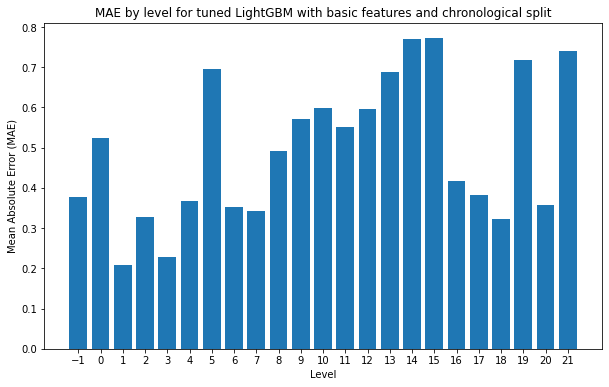

In [27]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and chronological split",
)

In [28]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Default:
MSE: 0.43
RMSE: 0.66

Round type: round
MSE: 0.48
RMSE: 0.69

Round type: 0.33
MSE: 0.47
RMSE: 0.69

Round type: 0.45
MSE: 0.48
RMSE: 0.69



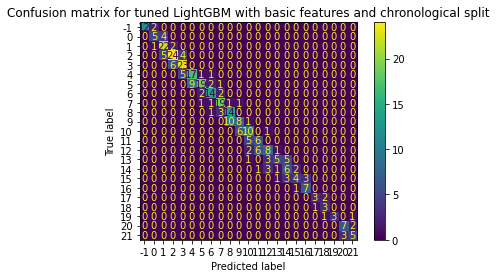

In [29]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with basic features and chronological split",
)

## Random split

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 8
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 0.340495	valid_0's l2: 0.243018


In [31]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.24
RMSE: 0.49
MAE: 0.34


In [33]:
results.loc[2] = ["random", "default", "basic", rmse, mae]

###### MAE by level

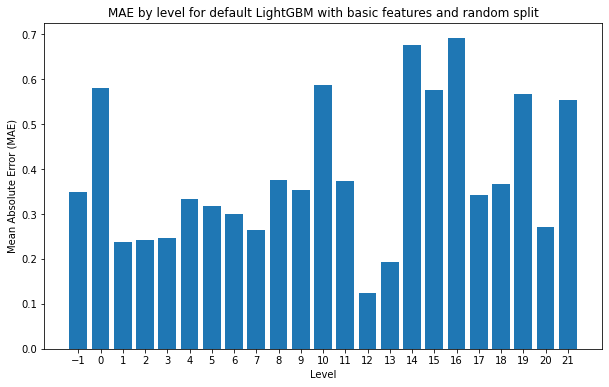

In [34]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and random split",
)

In [35]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
MSE: 0.24
RMSE: 0.49

Round type: round
MSE: 0.26
RMSE: 0.51

Round type: 0.33
MSE: 0.32
RMSE: 0.57

Round type: 0.45
MSE: 0.27
RMSE: 0.52



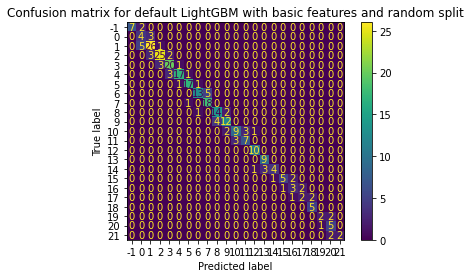

In [36]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with basic features and random split",
)

### Tuning

In [37]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 11:51:57,961] A new study created in memory with name: no-name-6cd171c1-51a9-4120-94af-e5506ec3111f
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.288916 + 0.0455643
[200]	cv_agg's l2: 0.276575 + 0.0436847


feature_fraction, val_score: 0.275081:  14%|######4                                      | 1/7 [00:00<00:05,  1.00it/s]

[300]	cv_agg's l2: 0.277375 + 0.0437907
Early stopping, best iteration is:
[234]	cv_agg's l2: 0.275081 + 0.0435848
[100]	cv_agg's l2: 0.256257 + 0.0405602


feature_fraction, val_score: 0.253261:  29%|############8                                | 2/7 [00:01<00:04,  1.10it/s]

[200]	cv_agg's l2: 0.254278 + 0.0414378
Early stopping, best iteration is:
[156]	cv_agg's l2: 0.253261 + 0.0398555


[I 2023-11-05 11:51:59,809] Trial 1 finished with value: 0.25326127644934593 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.25326127644934593.
feature_fraction, val_score: 0.253261:  29%|############8                                | 2/7 [00:01<00:04,  1.10it/s]

[100]	cv_agg's l2: 0.256328 + 0.0777765


feature_fraction, val_score: 0.253261:  29%|############8                                | 2/7 [00:02<00:04,  1.10it/s]

[200]	cv_agg's l2: 0.259774 + 0.07799
Early stopping, best iteration is:
[156]	cv_agg's l2: 0.253261 + 0.0398555


feature_fraction, val_score: 0.253261:  43%|###################2                         | 3/7 [00:02<00:03,  1.17it/s]

[100]	cv_agg's l2: 0.245938 + 0.0599602


feature_fraction, val_score: 0.245242:  57%|#########################7                   | 4/7 [00:03<00:02,  1.32it/s]

Early stopping, best iteration is:
[93]	cv_agg's l2: 0.245242 + 0.0607037
[100]	cv_agg's l2: 0.256257 + 0.0405602


feature_fraction, val_score: 0.245242:  71%|################################1            | 5/7 [00:03<00:01,  1.41it/s]

Early stopping, best iteration is:
[93]	cv_agg's l2: 0.245242 + 0.0607037
[100]	cv_agg's l2: 0.271215 + 0.0413307


feature_fraction, val_score: 0.245242:  86%|######################################5      | 6/7 [00:04<00:00,  1.51it/s]

Early stopping, best iteration is:
[93]	cv_agg's l2: 0.245242 + 0.0607037
[100]	cv_agg's l2: 0.414321 + 0.0439389


feature_fraction, val_score: 0.245242: 100%|#############################################| 7/7 [00:04<00:00,  1.40it/s]


Early stopping, best iteration is:
[93]	cv_agg's l2: 0.245242 + 0.0607037


num_leaves, val_score: 0.245242:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.243374 + 0.0579458
[200]	cv_agg's l2: 0.243183 + 0.0556941


num_leaves, val_score: 0.242073:   5%|##5                                               | 1/20 [00:00<00:10,  1.87it/s]

Early stopping, best iteration is:
[137]	cv_agg's l2: 0.242073 + 0.0573948
[100]	cv_agg's l2: 0.245938 + 0.0599602


num_leaves, val_score: 0.242073:  10%|#####                                             | 2/20 [00:01<00:12,  1.43it/s]

[200]	cv_agg's l2: 0.247892 + 0.0575923
Early stopping, best iteration is:
[137]	cv_agg's l2: 0.242073 + 0.0573948
[100]	cv_agg's l2: 0.245938 + 0.0599602
[200]	cv_agg's l2: 0.247892 + 0.0575923


num_leaves, val_score: 0.242073:  15%|#######5                                          | 3/20 [00:02<00:13,  1.22it/s]

Early stopping, best iteration is:
[137]	cv_agg's l2: 0.242073 + 0.0573948
[100]	cv_agg's l2: 0.246577 + 0.0699387
[200]	cv_agg's l2: 0.242229 + 0.0641341
[300]	cv_agg's l2: 0.243714 + 0.0642599


num_leaves, val_score: 0.241785:  20%|##########                                        | 4/20 [00:02<00:11,  1.37it/s]

Early stopping, best iteration is:
[265]	cv_agg's l2: 0.241785 + 0.0637377
[100]	cv_agg's l2: 0.252137 + 0.0764169
[200]	cv_agg's l2: 0.244456 + 0.0694086
[300]	cv_agg's l2: 0.242579 + 0.0674636


num_leaves, val_score: 0.240979:  25%|############5                                     | 5/20 [00:03<00:10,  1.49it/s]

[400]	cv_agg's l2: 0.241725 + 0.0656056
Early stopping, best iteration is:
[376]	cv_agg's l2: 0.240979 + 0.064527
[100]	cv_agg's l2: 0.252141 + 0.0681024
[200]	cv_agg's l2: 0.246235 + 0.0649924
[300]	cv_agg's l2: 0.246301 + 0.0643849
[400]	cv_agg's l2: 0.245565 + 0.0634427


num_leaves, val_score: 0.240979:  30%|###############                                   | 6/20 [00:04<00:09,  1.51it/s]

Early stopping, best iteration is:
[376]	cv_agg's l2: 0.240979 + 0.064527
[100]	cv_agg's l2: 0.245938 + 0.0599602
[200]	cv_agg's l2: 0.247892 + 0.0575923
[300]	cv_agg's l2: 0.251639 + 0.0559805
[400]	cv_agg's l2: 0.254542 + 0.0554977


num_leaves, val_score: 0.240979:  35%|#################5                                | 7/20 [00:05<00:12,  1.03it/s]

Early stopping, best iteration is:
[376]	cv_agg's l2: 0.240979 + 0.064527
[100]	cv_agg's l2: 0.245938 + 0.0599602
[200]	cv_agg's l2: 0.247892 + 0.0575923
[300]	cv_agg's l2: 0.251639 + 0.0559805
[400]	cv_agg's l2: 0.254542 + 0.0554977


num_leaves, val_score: 0.240979:  40%|####################                              | 8/20 [00:07<00:14,  1.18s/it]

Early stopping, best iteration is:
[376]	cv_agg's l2: 0.240979 + 0.064527
[100]	cv_agg's l2: 0.245938 + 0.0599602
[200]	cv_agg's l2: 0.247892 + 0.0575923
[300]	cv_agg's l2: 0.251639 + 0.0559805
[400]	cv_agg's l2: 0.254542 + 0.0554977


num_leaves, val_score: 0.240979:  45%|######################5                           | 9/20 [00:08<00:14,  1.31s/it]

Early stopping, best iteration is:
[376]	cv_agg's l2: 0.240979 + 0.064527
[100]	cv_agg's l2: 0.335345 + 0.0908588
[200]	cv_agg's l2: 0.297417 + 0.0804349


num_leaves, val_score: 0.240979:  50%|########################5                        | 10/20 [00:09<00:10,  1.02s/it]

[300]	cv_agg's l2: 0.291608 + 0.0782974
[400]	cv_agg's l2: 0.288991 + 0.0773455
Early stopping, best iteration is:
[376]	cv_agg's l2: 0.240979 + 0.064527
[100]	cv_agg's l2: 0.245938 + 0.0599602
[200]	cv_agg's l2: 0.247892 + 0.0575923
[300]	cv_agg's l2: 0.251639 + 0.0559805
[400]	cv_agg's l2: 0.254542 + 0.0554977


num_leaves, val_score: 0.240979:  55%|##########################9                      | 11/20 [00:10<00:10,  1.18s/it]

Early stopping, best iteration is:
[376]	cv_agg's l2: 0.240979 + 0.064527
[100]	cv_agg's l2: 0.245938 + 0.0599602
[200]	cv_agg's l2: 0.247892 + 0.0575923
[300]	cv_agg's l2: 0.251639 + 0.0559805
[400]	cv_agg's l2: 0.254542 + 0.0554977


num_leaves, val_score: 0.240979:  60%|#############################4                   | 12/20 [00:12<00:10,  1.31s/it]

Early stopping, best iteration is:
[376]	cv_agg's l2: 0.240979 + 0.064527
[100]	cv_agg's l2: 0.245938 + 0.0599602
[200]	cv_agg's l2: 0.247892 + 0.0575923
[300]	cv_agg's l2: 0.251639 + 0.0559805
[400]	cv_agg's l2: 0.254542 + 0.0554977


num_leaves, val_score: 0.240979:  65%|###############################8                 | 13/20 [00:14<00:09,  1.40s/it]

Early stopping, best iteration is:
[376]	cv_agg's l2: 0.240979 + 0.064527
[100]	cv_agg's l2: 0.245938 + 0.0599602
[200]	cv_agg's l2: 0.247892 + 0.0575923
[300]	cv_agg's l2: 0.251639 + 0.0559805
[400]	cv_agg's l2: 0.254542 + 0.0554977


num_leaves, val_score: 0.240979:  70%|##################################3              | 14/20 [00:15<00:08,  1.45s/it]

Early stopping, best iteration is:
[376]	cv_agg's l2: 0.240979 + 0.064527
[100]	cv_agg's l2: 0.246577 + 0.0699387
[200]	cv_agg's l2: 0.242229 + 0.0641341
[300]	cv_agg's l2: 0.243714 + 0.0642599


num_leaves, val_score: 0.240979:  75%|####################################7            | 15/20 [00:16<00:06,  1.23s/it]

[400]	cv_agg's l2: 0.243618 + 0.0617757
Early stopping, best iteration is:
[376]	cv_agg's l2: 0.240979 + 0.064527
[100]	cv_agg's l2: 0.245938 + 0.0599602
[200]	cv_agg's l2: 0.247892 + 0.0575923
[300]	cv_agg's l2: 0.251639 + 0.0559805
[400]	cv_agg's l2: 0.254542 + 0.0554977


num_leaves, val_score: 0.240979:  80%|#######################################2         | 16/20 [00:17<00:05,  1.32s/it]

Early stopping, best iteration is:
[376]	cv_agg's l2: 0.240979 + 0.064527
[100]	cv_agg's l2: 0.245938 + 0.0599602
[200]	cv_agg's l2: 0.247892 + 0.0575923
[300]	cv_agg's l2: 0.251639 + 0.0559805
[400]	cv_agg's l2: 0.254542 + 0.0554977


num_leaves, val_score: 0.240979:  85%|#########################################6       | 17/20 [00:19<00:04,  1.37s/it]

Early stopping, best iteration is:
[376]	cv_agg's l2: 0.240979 + 0.064527
[100]	cv_agg's l2: 0.245938 + 0.0599602
[200]	cv_agg's l2: 0.247892 + 0.0575923
[300]	cv_agg's l2: 0.251639 + 0.0559805
[400]	cv_agg's l2: 0.254542 + 0.0554977


num_leaves, val_score: 0.240979:  90%|############################################1    | 18/20 [00:20<00:02,  1.44s/it]

Early stopping, best iteration is:
[376]	cv_agg's l2: 0.240979 + 0.064527
[100]	cv_agg's l2: 0.246436 + 0.0639633
[200]	cv_agg's l2: 0.247863 + 0.0597035
[300]	cv_agg's l2: 0.251155 + 0.0556175
[400]	cv_agg's l2: 0.255046 + 0.054548


num_leaves, val_score: 0.240979:  95%|##############################################5  | 19/20 [00:22<00:01,  1.45s/it]

Early stopping, best iteration is:
[376]	cv_agg's l2: 0.240979 + 0.064527
[100]	cv_agg's l2: 0.242281 + 0.0574748
[200]	cv_agg's l2: 0.242056 + 0.0520199
[300]	cv_agg's l2: 0.244398 + 0.0481632
[400]	cv_agg's l2: 0.248163 + 0.0474973


num_leaves, val_score: 0.240979: 100%|#################################################| 20/20 [00:23<00:00,  1.20s/it]


Early stopping, best iteration is:
[376]	cv_agg's l2: 0.240979 + 0.064527


bagging, val_score: 0.240979:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.247396 + 0.0664319
[200]	cv_agg's l2: 0.242778 + 0.0623431
[300]	cv_agg's l2: 0.238506 + 0.0580318
[400]	cv_agg's l2: 0.237513 + 0.0542132


bagging, val_score: 0.237028:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[500]	cv_agg's l2: 0.237938 + 0.0520454
Early stopping, best iteration is:
[416]	cv_agg's l2: 0.237028 + 0.0537993


bagging, val_score: 0.237028:  10%|#####3                                               | 1/10 [00:00<00:07,  1.22it/s]

[100]	cv_agg's l2: 0.246202 + 0.0649493
[200]	cv_agg's l2: 0.241073 + 0.0597333
[300]	cv_agg's l2: 0.240485 + 0.0558306
[400]	cv_agg's l2: 0.239003 + 0.0532596


bagging, val_score: 0.237028:  20%|##########6                                          | 2/10 [00:01<00:06,  1.15it/s]

[500]	cv_agg's l2: 0.239321 + 0.0510023
Early stopping, best iteration is:
[416]	cv_agg's l2: 0.237028 + 0.0537993
[100]	cv_agg's l2: 0.247446 + 0.0631922
[200]	cv_agg's l2: 0.241517 + 0.0590616
[300]	cv_agg's l2: 0.239852 + 0.0562756
[400]	cv_agg's l2: 0.238268 + 0.0524288


bagging, val_score: 0.237028:  30%|###############9                                     | 3/10 [00:02<00:06,  1.16it/s]

[500]	cv_agg's l2: 0.238539 + 0.0519495
Early stopping, best iteration is:
[416]	cv_agg's l2: 0.237028 + 0.0537993
[100]	cv_agg's l2: 0.249701 + 0.0651724
[200]	cv_agg's l2: 0.244537 + 0.0598539
[300]	cv_agg's l2: 0.241357 + 0.058496


bagging, val_score: 0.237028:  40%|#####################2                               | 4/10 [00:03<00:04,  1.24it/s]

[400]	cv_agg's l2: 0.240174 + 0.0574709
[500]	cv_agg's l2: 0.240369 + 0.0550105
Early stopping, best iteration is:
[416]	cv_agg's l2: 0.237028 + 0.0537993
[100]	cv_agg's l2: 0.248211 + 0.0677049
[200]	cv_agg's l2: 0.241124 + 0.0625199
[300]	cv_agg's l2: 0.237609 + 0.0622606
[400]	cv_agg's l2: 0.238648 + 0.0596422


bagging, val_score: 0.237028:  50%|##########################5                          | 5/10 [00:04<00:03,  1.29it/s]

[500]	cv_agg's l2: 0.239597 + 0.0583262
Early stopping, best iteration is:
[416]	cv_agg's l2: 0.237028 + 0.0537993
[100]	cv_agg's l2: 0.246689 + 0.0667672
[200]	cv_agg's l2: 0.243222 + 0.0608555
[300]	cv_agg's l2: 0.238216 + 0.058366
[400]	cv_agg's l2: 0.238509 + 0.0551532


bagging, val_score: 0.237028:  60%|###############################8                     | 6/10 [00:04<00:03,  1.27it/s]

[500]	cv_agg's l2: 0.239629 + 0.054669
Early stopping, best iteration is:
[416]	cv_agg's l2: 0.237028 + 0.0537993
[100]	cv_agg's l2: 0.248192 + 0.0665222
[200]	cv_agg's l2: 0.24333 + 0.0632192
[300]	cv_agg's l2: 0.241523 + 0.0626927
[400]	cv_agg's l2: 0.241445 + 0.0609585


bagging, val_score: 0.237028:  70%|#####################################                | 7/10 [00:05<00:02,  1.26it/s]

[500]	cv_agg's l2: 0.240578 + 0.0590559
Early stopping, best iteration is:
[416]	cv_agg's l2: 0.237028 + 0.0537993
[100]	cv_agg's l2: 0.248202 + 0.0617818
[200]	cv_agg's l2: 0.24416 + 0.060756
[300]	cv_agg's l2: 0.241425 + 0.0599405
[400]	cv_agg's l2: 0.240952 + 0.0583814


bagging, val_score: 0.237028:  80%|##########################################4          | 8/10 [00:06<00:01,  1.19it/s]

[500]	cv_agg's l2: 0.242276 + 0.0594855
Early stopping, best iteration is:
[416]	cv_agg's l2: 0.237028 + 0.0537993
[100]	cv_agg's l2: 0.249606 + 0.0687556
[200]	cv_agg's l2: 0.245815 + 0.0612684
[300]	cv_agg's l2: 0.240164 + 0.0586151
[400]	cv_agg's l2: 0.23996 + 0.0543017


bagging, val_score: 0.237028:  90%|###############################################7     | 9/10 [00:07<00:00,  1.13it/s]

[500]	cv_agg's l2: 0.240478 + 0.0523083
Early stopping, best iteration is:
[416]	cv_agg's l2: 0.237028 + 0.0537993
[100]	cv_agg's l2: 0.309514 + 0.0640561
[200]	cv_agg's l2: 0.296847 + 0.0615951
[300]	cv_agg's l2: 0.30313 + 0.056004


bagging, val_score: 0.237028:  90%|###############################################7     | 9/10 [00:08<00:00,  1.13it/s]

[400]	cv_agg's l2: 0.297352 + 0.0585821
[500]	cv_agg's l2: 0.288262 + 0.0590116
Early stopping, best iteration is:
[416]	cv_agg's l2: 0.237028 + 0.0537993


feature_fraction_stage2, val_score: 0.237028:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.251695 + 0.0746515
[200]	cv_agg's l2: 0.243008 + 0.0725414
[300]	cv_agg's l2: 0.239054 + 0.0708579
[400]	cv_agg's l2: 0.236044 + 0.0689932
[500]	cv_agg's l2: 0.236328 + 0.0677242
Early stopping, best iteration is:
[459]	cv_agg's l2: 0.235811 + 0.0678348


feature_fraction_stage2, val_score: 0.235811:  17%|######3                               | 1/6 [00:01<00:05,  1.01s/it]

[100]	cv_agg's l2: 0.251695 + 0.0746515
[200]	cv_agg's l2: 0.243008 + 0.0725414
[300]	cv_agg's l2: 0.239054 + 0.0708579
[400]	cv_agg's l2: 0.236044 + 0.0689932
[500]	cv_agg's l2: 0.236328 + 0.0677242


feature_fraction_stage2, val_score: 0.235811:  33%|############6                         | 2/6 [00:01<00:03,  1.04it/s]

Early stopping, best iteration is:
[459]	cv_agg's l2: 0.235811 + 0.0678348
[100]	cv_agg's l2: 0.247396 + 0.0664319
[200]	cv_agg's l2: 0.242778 + 0.0623431
[300]	cv_agg's l2: 0.238506 + 0.0580318
[400]	cv_agg's l2: 0.237513 + 0.0542132
[500]	cv_agg's l2: 0.237938 + 0.0520454


feature_fraction_stage2, val_score: 0.235811:  50%|###################                   | 3/6 [00:02<00:02,  1.08it/s]

Early stopping, best iteration is:
[459]	cv_agg's l2: 0.235811 + 0.0678348
[100]	cv_agg's l2: 0.247396 + 0.0664319
[200]	cv_agg's l2: 0.242778 + 0.0623431
[300]	cv_agg's l2: 0.238506 + 0.0580318
[400]	cv_agg's l2: 0.237513 + 0.0542132
[500]	cv_agg's l2: 0.237938 + 0.0520454


feature_fraction_stage2, val_score: 0.235811:  67%|#########################3            | 4/6 [00:03<00:01,  1.14it/s]

Early stopping, best iteration is:
[459]	cv_agg's l2: 0.235811 + 0.0678348
[100]	cv_agg's l2: 0.247396 + 0.0664319
[200]	cv_agg's l2: 0.242778 + 0.0623431
[300]	cv_agg's l2: 0.238506 + 0.0580318
[400]	cv_agg's l2: 0.237513 + 0.0542132
[500]	cv_agg's l2: 0.237938 + 0.0520454


feature_fraction_stage2, val_score: 0.235811:  83%|###############################6      | 5/6 [00:04<00:00,  1.12it/s]

Early stopping, best iteration is:
[459]	cv_agg's l2: 0.235811 + 0.0678348
[100]	cv_agg's l2: 0.247396 + 0.0664319
[200]	cv_agg's l2: 0.242778 + 0.0623431
[300]	cv_agg's l2: 0.238506 + 0.0580318
[400]	cv_agg's l2: 0.237513 + 0.0542132


feature_fraction_stage2, val_score: 0.235811: 100%|######################################| 6/6 [00:05<00:00,  1.11it/s]


[500]	cv_agg's l2: 0.237938 + 0.0520454
Early stopping, best iteration is:
[459]	cv_agg's l2: 0.235811 + 0.0678348


regularization_factors, val_score: 0.235811:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.250558 + 0.0724661
[200]	cv_agg's l2: 0.241054 + 0.0694397
[300]	cv_agg's l2: 0.238515 + 0.068303
[400]	cv_agg's l2: 0.23785 + 0.067608


regularization_factors, val_score: 0.235806:   5%|#9                                    | 1/20 [00:01<00:19,  1.03s/it]

[500]	cv_agg's l2: 0.23589 + 0.0640383
Early stopping, best iteration is:
[497]	cv_agg's l2: 0.235806 + 0.0642187
[100]	cv_agg's l2: 0.24896 + 0.0722826
[200]	cv_agg's l2: 0.23953 + 0.0663353


regularization_factors, val_score: 0.234399:   5%|#9                                    | 1/20 [00:01<00:19,  1.03s/it]

[300]	cv_agg's l2: 0.236319 + 0.0629903
[400]	cv_agg's l2: 0.235364 + 0.0589555
Early stopping, best iteration is:
[345]	cv_agg's l2: 0.234399 + 0.0596944


regularization_factors, val_score: 0.234399:  10%|###8                                  | 2/20 [00:01<00:14,  1.24it/s]

[100]	cv_agg's l2: 0.250673 + 0.0706098
[200]	cv_agg's l2: 0.239592 + 0.0648001


regularization_factors, val_score: 0.234399:  10%|###8                                  | 2/20 [00:02<00:14,  1.24it/s]

[300]	cv_agg's l2: 0.236516 + 0.062939
[400]	cv_agg's l2: 0.235138 + 0.060609
Early stopping, best iteration is:
[345]	cv_agg's l2: 0.234399 + 0.0596944


regularization_factors, val_score: 0.234399:  15%|#####7                                | 3/20 [00:02<00:12,  1.34it/s]

[100]	cv_agg's l2: 0.251401 + 0.0688794
[200]	cv_agg's l2: 0.24163 + 0.0662022
[300]	cv_agg's l2: 0.236648 + 0.062464
[400]	cv_agg's l2: 0.233719 + 0.0603372


regularization_factors, val_score: 0.233431:  20%|#######6                              | 4/20 [00:03<00:12,  1.33it/s]

[500]	cv_agg's l2: 0.234435 + 0.058534
Early stopping, best iteration is:
[408]	cv_agg's l2: 0.233431 + 0.0598985
[100]	cv_agg's l2: 0.251154 + 0.0707217
[200]	cv_agg's l2: 0.240698 + 0.0687009
[300]	cv_agg's l2: 0.240255 + 0.0667729


regularization_factors, val_score: 0.233431:  25%|#########5                            | 5/20 [00:03<00:11,  1.30it/s]

[400]	cv_agg's l2: 0.237659 + 0.0641719
[500]	cv_agg's l2: 0.238971 + 0.0640259
Early stopping, best iteration is:
[408]	cv_agg's l2: 0.233431 + 0.0598985
[100]	cv_agg's l2: 0.248926 + 0.0705135
[200]	cv_agg's l2: 0.239657 + 0.0664459
[300]	cv_agg's l2: 0.23593 + 0.0630664
[400]	cv_agg's l2: 0.23442 + 0.060167


regularization_factors, val_score: 0.233431:  30%|###########4                          | 6/20 [00:04<00:10,  1.27it/s]

[500]	cv_agg's l2: 0.234446 + 0.0590137
Early stopping, best iteration is:
[408]	cv_agg's l2: 0.233431 + 0.0598985
[100]	cv_agg's l2: 0.250517 + 0.0706833
[200]	cv_agg's l2: 0.239624 + 0.0653992
[300]	cv_agg's l2: 0.235384 + 0.0621997


regularization_factors, val_score: 0.233431:  35%|#############3                        | 7/20 [00:05<00:10,  1.29it/s]

[400]	cv_agg's l2: 0.234074 + 0.0602731
[500]	cv_agg's l2: 0.235662 + 0.0598273
Early stopping, best iteration is:
[408]	cv_agg's l2: 0.233431 + 0.0598985
[100]	cv_agg's l2: 0.25053 + 0.0689886
[200]	cv_agg's l2: 0.240067 + 0.0669135
[300]	cv_agg's l2: 0.237692 + 0.0622988
[400]	cv_agg's l2: 0.236067 + 0.059285


regularization_factors, val_score: 0.233431:  40%|###############2                      | 8/20 [00:06<00:09,  1.32it/s]

[500]	cv_agg's l2: 0.237676 + 0.0572578
Early stopping, best iteration is:
[408]	cv_agg's l2: 0.233431 + 0.0598985
[100]	cv_agg's l2: 0.251155 + 0.0707216
[200]	cv_agg's l2: 0.240924 + 0.0685875
[300]	cv_agg's l2: 0.239809 + 0.0668279


regularization_factors, val_score: 0.233431:  45%|#################1                    | 9/20 [00:06<00:08,  1.34it/s]

[400]	cv_agg's l2: 0.237967 + 0.063919
[500]	cv_agg's l2: 0.239033 + 0.0638965
Early stopping, best iteration is:
[408]	cv_agg's l2: 0.233431 + 0.0598985
[100]	cv_agg's l2: 0.248384 + 0.0706329
[200]	cv_agg's l2: 0.237998 + 0.0664077
[300]	cv_agg's l2: 0.235084 + 0.0625144
[400]	cv_agg's l2: 0.232665 + 0.0602051


regularization_factors, val_score: 0.231717:  50%|##################5                  | 10/20 [00:07<00:08,  1.24it/s]

[500]	cv_agg's l2: 0.23222 + 0.0595826
Early stopping, best iteration is:
[494]	cv_agg's l2: 0.231717 + 0.0593825
[100]	cv_agg's l2: 0.24854 + 0.0712338
[200]	cv_agg's l2: 0.238571 + 0.0654653
[300]	cv_agg's l2: 0.236483 + 0.0633436
[400]	cv_agg's l2: 0.23416 + 0.0615194


regularization_factors, val_score: 0.231717:  55%|####################3                | 11/20 [00:08<00:08,  1.11it/s]

[500]	cv_agg's l2: 0.235088 + 0.0599413
Early stopping, best iteration is:
[494]	cv_agg's l2: 0.231717 + 0.0593825
[100]	cv_agg's l2: 0.246518 + 0.0684572
[200]	cv_agg's l2: 0.235871 + 0.0608507
[300]	cv_agg's l2: 0.233818 + 0.0585396
[400]	cv_agg's l2: 0.232931 + 0.0562189


regularization_factors, val_score: 0.231717:  60%|######################2              | 12/20 [00:09<00:07,  1.11it/s]

[500]	cv_agg's l2: 0.234707 + 0.0560073
Early stopping, best iteration is:
[494]	cv_agg's l2: 0.231717 + 0.0593825
[100]	cv_agg's l2: 0.243396 + 0.0572938
[200]	cv_agg's l2: 0.236329 + 0.0569573
[300]	cv_agg's l2: 0.236039 + 0.0539567
[400]	cv_agg's l2: 0.234285 + 0.0533814


regularization_factors, val_score: 0.231717:  65%|########################             | 13/20 [00:10<00:06,  1.12it/s]

[500]	cv_agg's l2: 0.233165 + 0.0517246
Early stopping, best iteration is:
[494]	cv_agg's l2: 0.231717 + 0.0593825
[100]	cv_agg's l2: 0.254218 + 0.065061
[200]	cv_agg's l2: 0.245047 + 0.0633432
[300]	cv_agg's l2: 0.242284 + 0.0620133
[400]	cv_agg's l2: 0.240436 + 0.0589007


regularization_factors, val_score: 0.231717:  70%|#########################9           | 14/20 [00:11<00:05,  1.07it/s]

[500]	cv_agg's l2: 0.238679 + 0.0558806
Early stopping, best iteration is:
[494]	cv_agg's l2: 0.231717 + 0.0593825
[100]	cv_agg's l2: 0.249251 + 0.056551
[200]	cv_agg's l2: 0.241408 + 0.0535573
[300]	cv_agg's l2: 0.238325 + 0.052937
[400]	cv_agg's l2: 0.236963 + 0.0509353


regularization_factors, val_score: 0.231717:  75%|###########################7         | 15/20 [00:12<00:04,  1.04it/s]

[500]	cv_agg's l2: 0.23593 + 0.0486858
Early stopping, best iteration is:
[494]	cv_agg's l2: 0.231717 + 0.0593825
[100]	cv_agg's l2: 0.252108 + 0.0745655
[200]	cv_agg's l2: 0.243825 + 0.0735177
[300]	cv_agg's l2: 0.240024 + 0.0705171
[400]	cv_agg's l2: 0.235709 + 0.0694239
[500]	cv_agg's l2: 0.2365 + 0.06918


regularization_factors, val_score: 0.231717:  80%|#############################6       | 16/20 [00:13<00:03,  1.03it/s]

Early stopping, best iteration is:
[494]	cv_agg's l2: 0.231717 + 0.0593825
[100]	cv_agg's l2: 0.251695 + 0.0746516
[200]	cv_agg's l2: 0.242565 + 0.0727489
[300]	cv_agg's l2: 0.238852 + 0.0709514
[400]	cv_agg's l2: 0.234874 + 0.0695141
[500]	cv_agg's l2: 0.235871 + 0.0692415


regularization_factors, val_score: 0.231717:  85%|###############################4     | 17/20 [00:14<00:02,  1.02it/s]

Early stopping, best iteration is:
[494]	cv_agg's l2: 0.231717 + 0.0593825
[100]	cv_agg's l2: 0.247476 + 0.0674074
[200]	cv_agg's l2: 0.237407 + 0.0658763
[300]	cv_agg's l2: 0.235788 + 0.0661448
[400]	cv_agg's l2: 0.233415 + 0.0661752
[500]	cv_agg's l2: 0.233259 + 0.0628655


regularization_factors, val_score: 0.231717:  90%|#################################3   | 18/20 [00:16<00:02,  1.05s/it]

Early stopping, best iteration is:
[494]	cv_agg's l2: 0.231717 + 0.0593825
[100]	cv_agg's l2: 0.246205 + 0.0640109
[200]	cv_agg's l2: 0.236164 + 0.0623647
[300]	cv_agg's l2: 0.232027 + 0.0575883


regularization_factors, val_score: 0.230690:  95%|###################################1 | 19/20 [00:16<00:00,  1.03it/s]

[400]	cv_agg's l2: 0.231223 + 0.0575838
Early stopping, best iteration is:
[353]	cv_agg's l2: 0.23069 + 0.0576382
[100]	cv_agg's l2: 0.248515 + 0.0657161
[200]	cv_agg's l2: 0.239584 + 0.0648266
[300]	cv_agg's l2: 0.237592 + 0.0616531
[400]	cv_agg's l2: 0.235749 + 0.0576728


regularization_factors, val_score: 0.230690: 100%|#####################################| 20/20 [00:17<00:00,  1.13it/s]


Early stopping, best iteration is:
[353]	cv_agg's l2: 0.23069 + 0.0576382


min_data_in_leaf, val_score: 0.230690:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.268828 + 0.0693633
[200]	cv_agg's l2: 0.262549 + 0.0714352
[300]	cv_agg's l2: 0.261773 + 0.0691351
[400]	cv_agg's l2: 0.260082 + 0.0669501


min_data_in_leaf, val_score: 0.230690:  20%|#########                                    | 1/5 [00:00<00:03,  1.22it/s]

Early stopping, best iteration is:
[353]	cv_agg's l2: 0.23069 + 0.0576382
[100]	cv_agg's l2: 0.33473 + 0.0728635
[200]	cv_agg's l2: 0.327009 + 0.0726074
[300]	cv_agg's l2: 0.326703 + 0.0710751
[400]	cv_agg's l2: 0.32148 + 0.0683689


min_data_in_leaf, val_score: 0.230690:  40%|##################                           | 2/5 [00:01<00:02,  1.24it/s]

Early stopping, best iteration is:
[353]	cv_agg's l2: 0.23069 + 0.0576382
[100]	cv_agg's l2: 0.230469 + 0.0552231
[200]	cv_agg's l2: 0.217635 + 0.0454146
[300]	cv_agg's l2: 0.214586 + 0.0432023


min_data_in_leaf, val_score: 0.212052:  60%|###########################                  | 3/5 [00:02<00:01,  1.28it/s]

[400]	cv_agg's l2: 0.213984 + 0.0441405
Early stopping, best iteration is:
[341]	cv_agg's l2: 0.212052 + 0.0428375
[100]	cv_agg's l2: 0.231613 + 0.056085
[200]	cv_agg's l2: 0.221954 + 0.0519867
[300]	cv_agg's l2: 0.221152 + 0.0519306
[400]	cv_agg's l2: 0.218731 + 0.0502392


min_data_in_leaf, val_score: 0.212052:  80%|####################################         | 4/5 [00:03<00:00,  1.30it/s]

Early stopping, best iteration is:
[341]	cv_agg's l2: 0.212052 + 0.0428375
[100]	cv_agg's l2: 0.841722 + 0.0595588
[200]	cv_agg's l2: 0.801784 + 0.0705984
[300]	cv_agg's l2: 0.786957 + 0.0788556


min_data_in_leaf, val_score: 0.212052: 100%|#############################################| 5/5 [00:03<00:00,  1.30it/s]

[400]	cv_agg's l2: 0.7818 + 0.0802179
Early stopping, best iteration is:
[341]	cv_agg's l2: 0.212052 + 0.0428375


In [38]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.21205172145338044
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 4.1730090410577264e-08
    lambda_l2: 1.879628580098759
    num_leaves: 6
    feature_fraction: 0.948
    bagging_fraction: 0.9695603306133047
    bagging_freq: 5
    min_child_samples: 5


In [39]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [40]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.01
RMSE test: 0.51
MSE test: 0.26
MAE test: 0.33



In [41]:
results.loc[3] = ["random", "Optuna", "basic", rmse, mae]

###### MAE by level

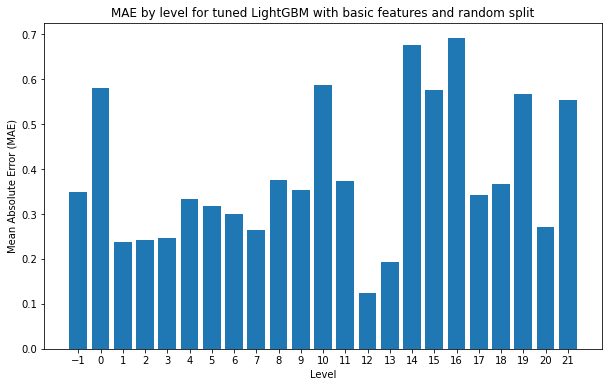

In [42]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and random split",
)

In [43]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Default:
MSE: 0.12
RMSE: 0.34

Round type: round
MSE: 0.14
RMSE: 0.37

Round type: 0.33
MSE: 0.13
RMSE: 0.36

Round type: 0.45
MSE: 0.13
RMSE: 0.37



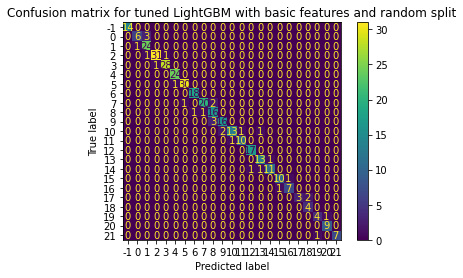

In [44]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with basic features and random split",
)

## Summary

In [45]:
results

,Split type,Tuning type,Set of features,MSE,RMSE,MAE
0,chronological,default,basic,0.447566,0.669004,0.467604
1,chronological,Optuna,basic,0.434207,0.658944,0.474985
2,random,default,basic,0.243018,0.492968,0.340495
3,random,Optuna,basic,0.260868,0.510753,0.329821


In [46]:
from training.results import plot_summary

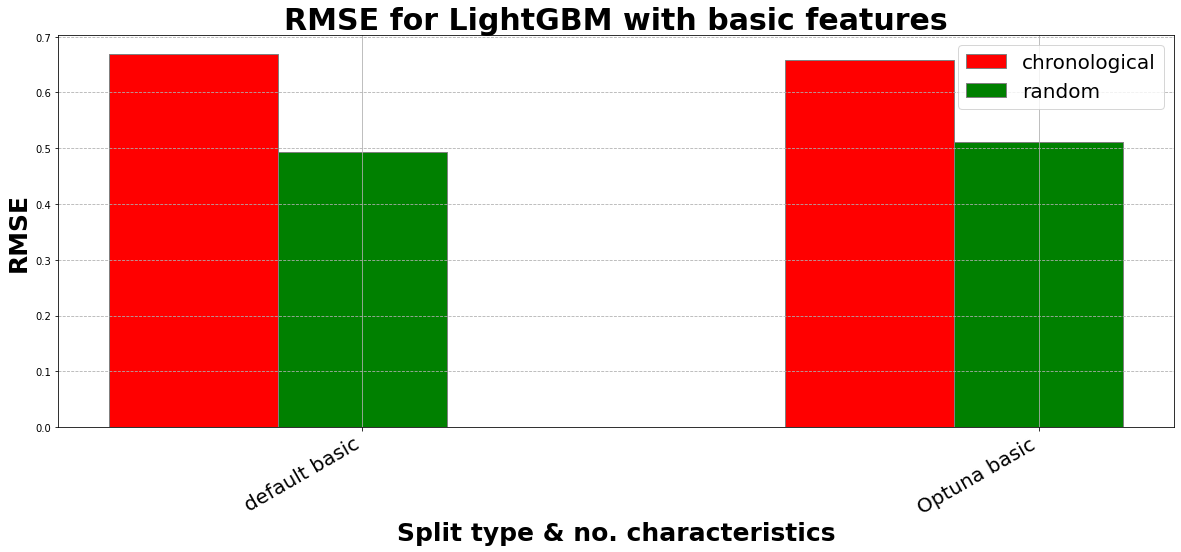

In [47]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with basic features")

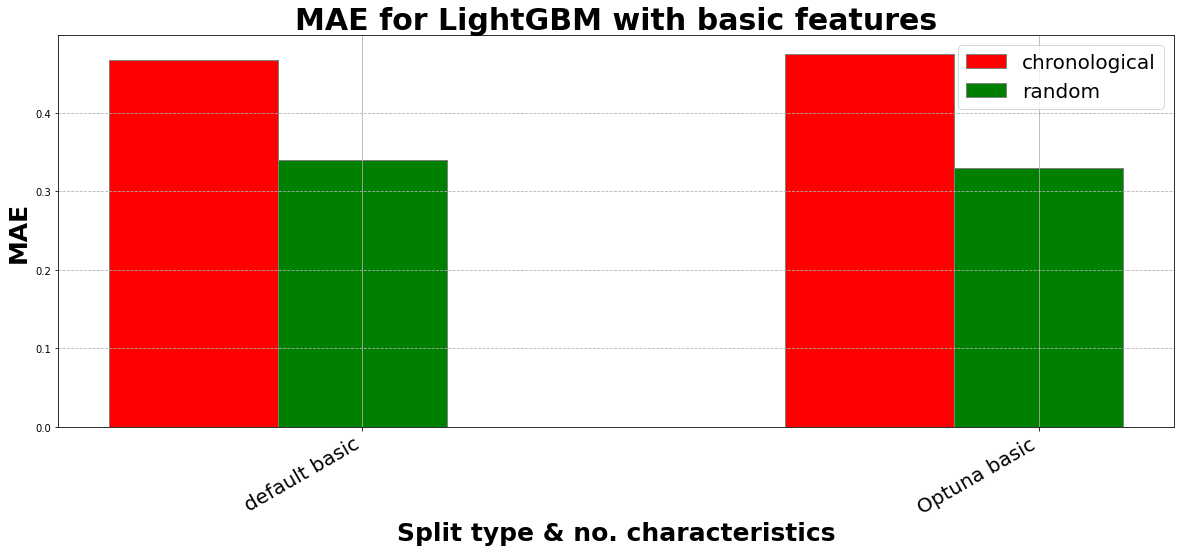

In [48]:
plot_summary(results, "MAE", title="MAE for LightGBM with basic features")

In [49]:
results.to_json("./lightgbm_basic_results.json", indent=2)